### Preamble

In [24]:
#################################################################
### This is for custom test cases for the PC algorithms
### Using the causal-learn package in a Juypiter notebook
#################################################################

### Install the relevant packages beforehand, including the causallearn package
import os, time
import sys
sys.path.append("")
import unittest
import hashlib
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq, fisherz, gsq, kci, mv_fisherz, d_separation
from causallearn.utils.cit import CIT
from causallearn.graph.SHD import SHD
from causallearn.utils.DAG2CPDAG import dag2cpdag
from causallearn.utils.TXT2GeneralGraph import txt2generalgraph
from causallearn.utils.Dataset import load_dataset
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.graph.ArrowConfusion import ArrowConfusion
from causallearn.graph.AdjacencyConfusion import AdjacencyConfusion
from IPython.display import Image, display
from pathlib import Path
import pandas as pd

# Other stuff to install:
# 1. https://graphviz.org/download/ and this to the system PATH when you are installing graphviz.


### Simulation IA: Comparing different types of CI test on Sach Data

In [25]:
data, labels = load_dataset("sachs")
df = pd.DataFrame(np.array(data),columns=labels)

# ------------------------------------------------------------------
# 3.  Standardise (zero mean, unit variance) column‑wise
# ------------------------------------------------------------------
df_std = (df - df.mean()) / df.std(ddof=0)
data = df_std.to_numpy(dtype=float)  # Convert the DataFrame to a NumPy array
# df_std is your z‑scored DataFrame
print(df_std.iloc[0:5, :])  # Print the first 5 rows and columns of the z‑scored DataFrame
print(data.shape) # (number of samples, number of variables)
print(labels)  # Labels of the variables


        raf       mek       plc      pip2      pip3       erk       akt  \
0 -0.394616 -0.350584 -0.264792 -0.443731  0.737945 -0.436918 -0.465800   
1 -0.356234 -0.341831 -0.244775 -0.448742 -0.439188 -0.175263 -0.353283   
2 -0.261289 -0.268628 -0.231545 -0.470791 -0.326051 -0.256007 -0.353283   
3 -0.206342 -0.165984 -0.182652 -0.459767 -0.598090 -0.453940 -0.503548   
4 -0.365122 -0.333079 -0.285673 -0.472361 -0.051921 -0.120706 -0.254559   

        pka       pkc       p38       jnk  
0 -0.328605 -0.143669 -0.182147 -0.154269  
1 -0.424816 -0.290443 -0.239551 -0.054569  
2 -0.345675 -0.203972 -0.208423 -0.249332  
3 -0.151701 -0.179205 -0.215094 -0.232638  
4 -0.497751 -0.276552 -0.220955  0.037248  
(7466, 11)
['raf', 'mek', 'plc', 'pip2', 'pip3', 'erk', 'akt', 'pka', 'pkc', 'p38', 'jnk']


#### Generating the true CPDAG

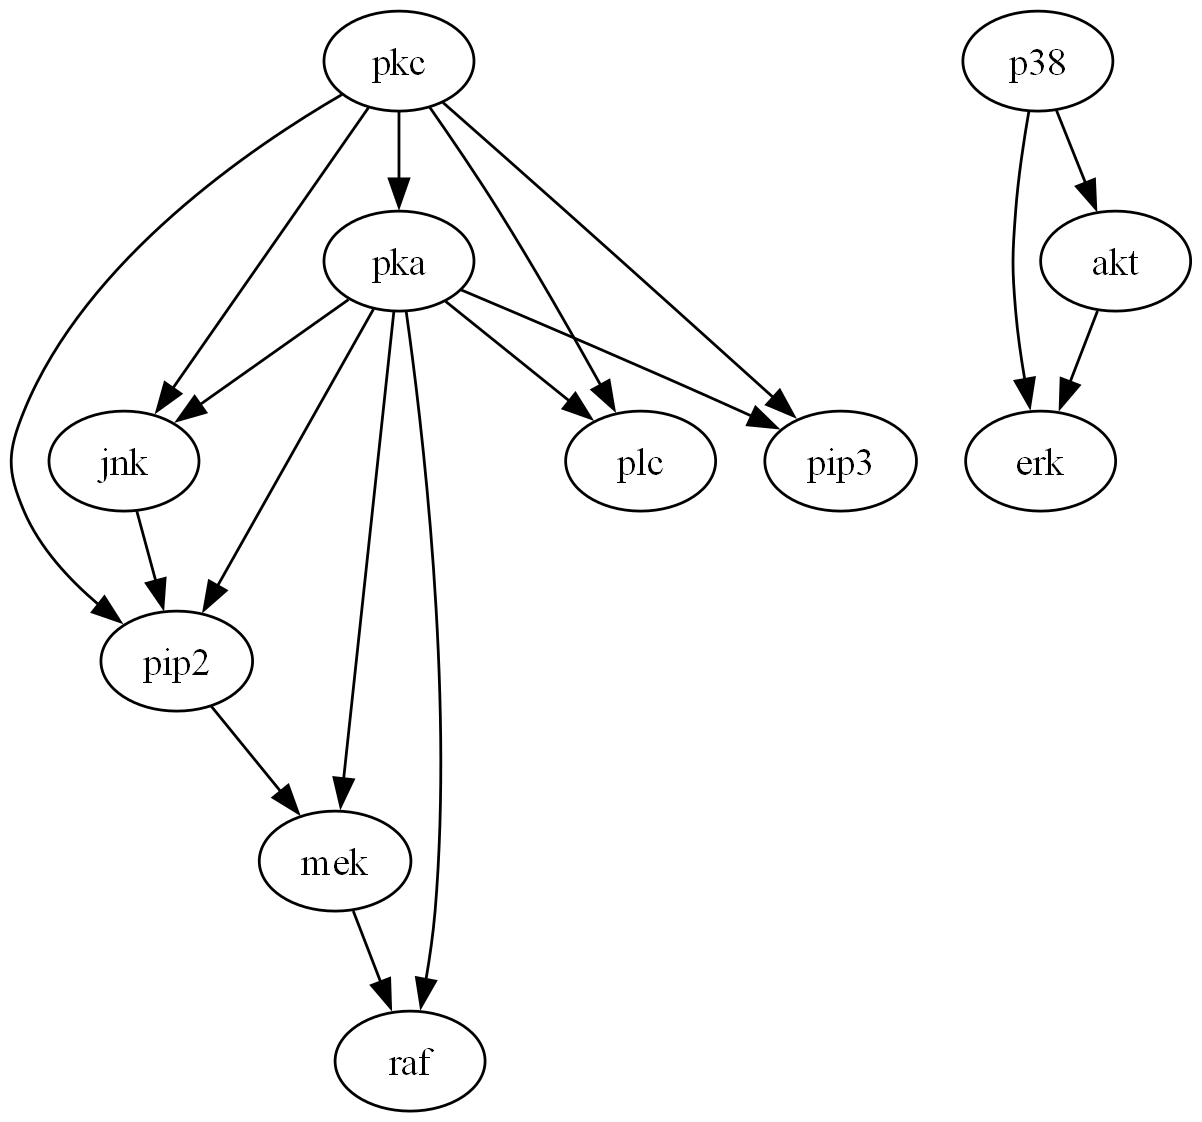

In [11]:
truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")
pyd = GraphUtils.to_pydot(truth_cpdag, labels=labels)
display(Image(pyd.create_png()))


#### CI Test: FisherZ

  0%|          | 0/11 [00:00<?, ?it/s]

0 dep 1 | () with p-value 0.000000

0 dep 2 | () with p-value 0.000000

0 dep 3 | () with p-value 0.000000

0 ind 4 | () with p-value 0.361725

0 dep 5 | () with p-value 0.014639

0 dep 6 | () with p-value 0.000000

0 dep 7 | () with p-value 0.000000

0 dep 8 | () with p-value 0.000000

0 dep 9 | () with p-value 0.000000

0 dep 10 | () with p-value 0.000000

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.000000

1 dep 3 | () with p-value 0.000000

1 ind 4 | () with p-value 0.138765

1 dep 5 | () with p-value 0.000618

1 dep 6 | () with p-value 0.000000

1 dep 7 | () with p-value 0.000000

1 dep 8 | () with p-value 0.000000

1 dep 9 | () with p-value 0.000000

1 dep 10 | () with p-value 0.000000

2 dep 0 | () with p-value 0.000000

2 dep 1 | () with p-value 0.000000

2 dep 3 | () with p-value 0.000000

2 dep 4 | () with p-value 0.000000

2 dep 5 | () with p-value 0.000000

2 dep 6 | () with p-value 0.000000

2 dep 7 | () with p-value 0.000000

2 dep 8 | () with p-value 

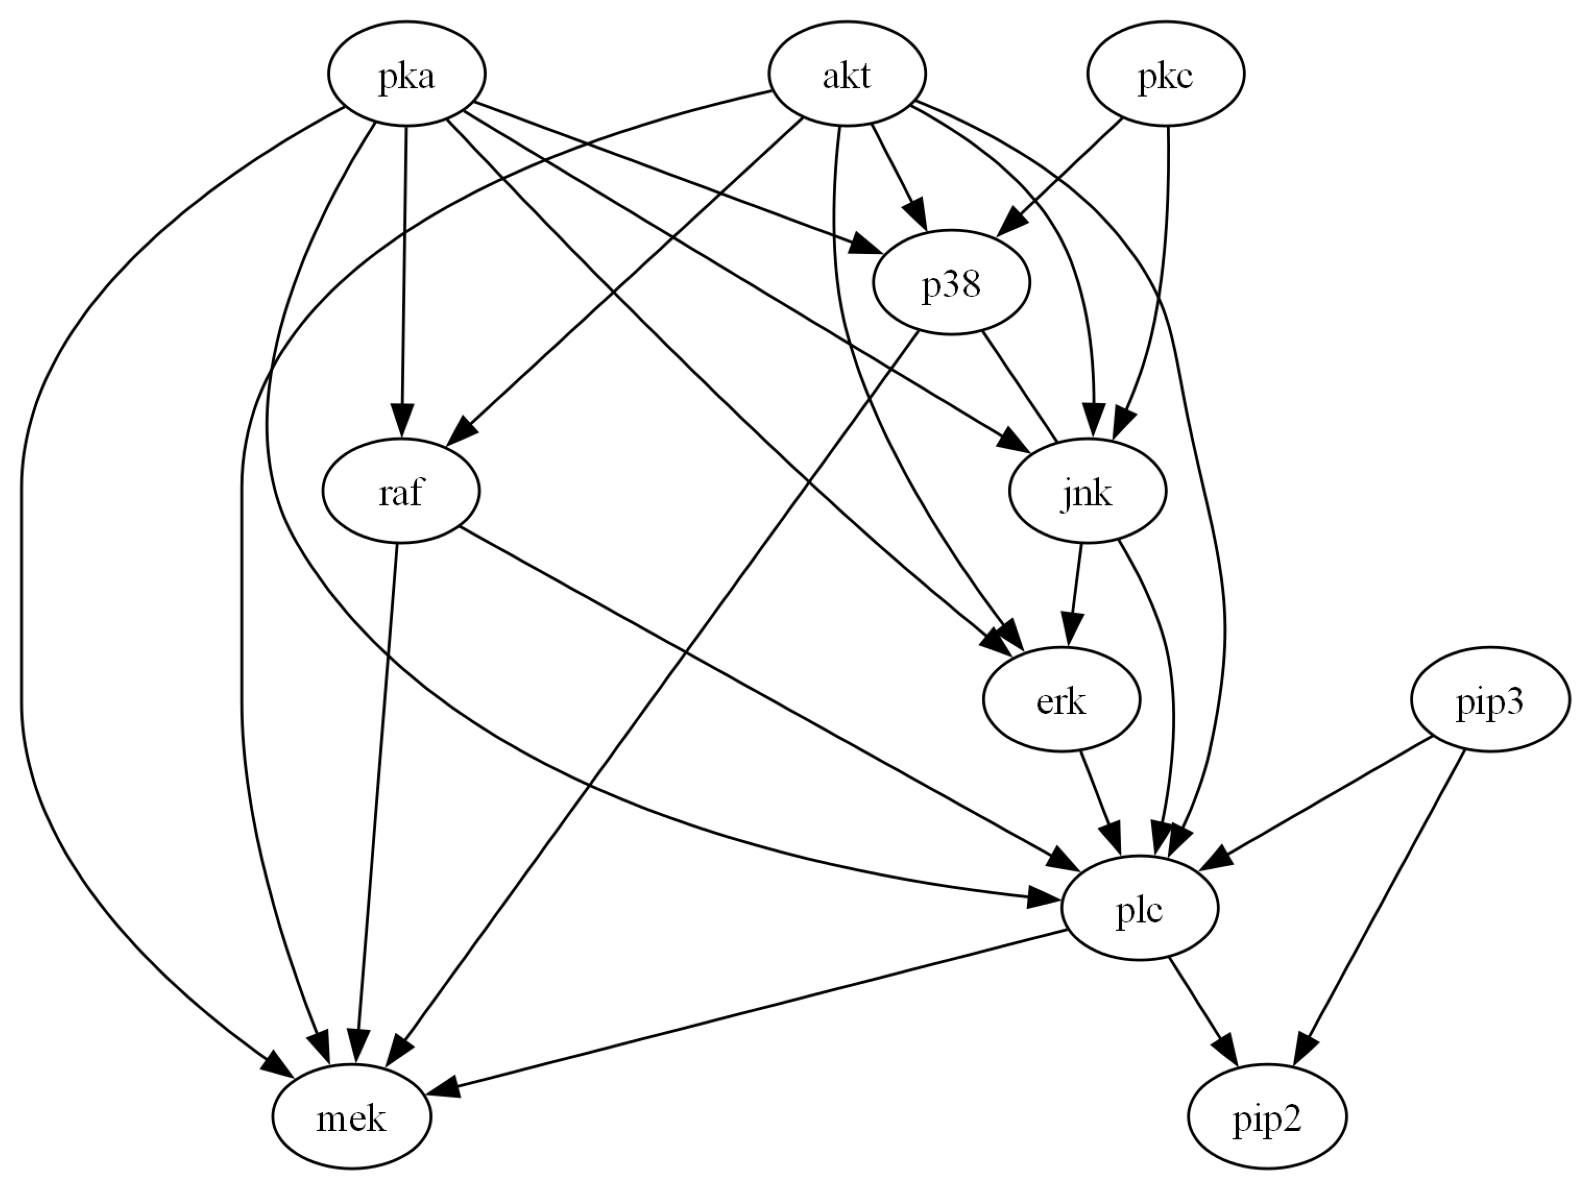

In [ ]:
# Run the PC algorithm with different parameters
start_time = time.monotonic()
cg_fisherz = pc(data,
        alpha = 0.05,
        indep_test = "fisherz",
        # parameters for the indep_test
        # end 
        stable = True,
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = True,
        show_progress = True
)
print("\n PC test using FisherZ completed.")
end_time = time.monotonic()
print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )


# Visualize using pydot and save the graph
cg_fisherz.draw_pydot_graph(labels=labels)
pyd_fisherz = GraphUtils.to_pydot(cg_fisherz.G, labels=labels)
pyd_fisherz.write_png('sach_fisherz.png')




In [72]:
# For arrows

est = cg_fisherz.G
truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")

adj   = AdjacencyConfusion(truth_cpdag, est)
arrow = ArrowConfusion(truth_cpdag, est)

arrow_stats = {
    "TP"       : arrow.get_arrows_tp(),
    "FP"       : arrow.get_arrows_fp(),
    "FN"       : arrow.get_arrows_fn(),
    #"TN"       : arrow.get_arrows_tn(),
    "Precision": round(arrow.get_arrows_precision(), 3),
    "Recall"   : round(arrow.get_arrows_recall(),    3),
    "F1"       : round(arrow.get_arrows_f1(),        3),
}

adj_stats = {
    "TP"       : adj.get_adj_tp(),
    "FP"       : adj.get_adj_fp(),
    "FN"       : adj.get_adj_fn(),
    #"TN"       : adj.get_adj_tn(),
    "Precision": round(adj.get_adj_precision(), 3),
    "Recall"   : round(adj.get_adj_recall(),    3),
    "F1"       : round(adj.get_adj_f1(),        3),
}

df = pd.DataFrame(
    [adj_stats, arrow_stats], 
    index=["Adjacency", "Arrow‑head"]
).T

#display(df.style.set_sticky()) 
display(df) 

# Structural Hamming Distance
shd = SHD(truth_cpdag, est).get_shd()
print("Structural Hamming Distance:", shd)

,Adjacency,Arrow‑head
TP,8.000,6.000
FP,17.000,18.000
FN,9.000,11.000
Precision,0.320,0.250
Recall,0.471,0.353
F1,0.381,0.293


Structural Hamming Distance: 28


#### CI Test: RCIT

  0%|          | 0/11 [00:00<?, ?it/s]

0 dep 1 | () with p-value 0.000000

0 dep 2 | () with p-value 0.000000

0 dep 3 | () with p-value 0.000000

0 dep 4 | () with p-value 0.000000

0 dep 5 | () with p-value 0.000000

0 dep 6 | () with p-value 0.000000

0 dep 7 | () with p-value 0.000000

0 dep 8 | () with p-value 0.000000

0 dep 9 | () with p-value 0.000000

0 dep 10 | () with p-value 0.000000

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.000000

1 dep 3 | () with p-value 0.000000

1 dep 4 | () with p-value 0.000000

1 dep 5 | () with p-value 0.016676

1 dep 6 | () with p-value 0.000000

1 dep 7 | () with p-value 0.000000

1 dep 8 | () with p-value 0.000000

1 dep 9 | () with p-value 0.000000

1 dep 10 | () with p-value 0.000000

2 dep 0 | () with p-value 0.000000

2 dep 1 | () with p-value 0.000000

2 dep 3 | () with p-value 0.000000

2 dep 4 | () with p-value 0.000000

2 dep 5 | () with p-value 0.000000

2 dep 6 | () with p-value 0.000000

2 dep 7 | () with p-value 0.000000

2 dep 8 | () with p-value 

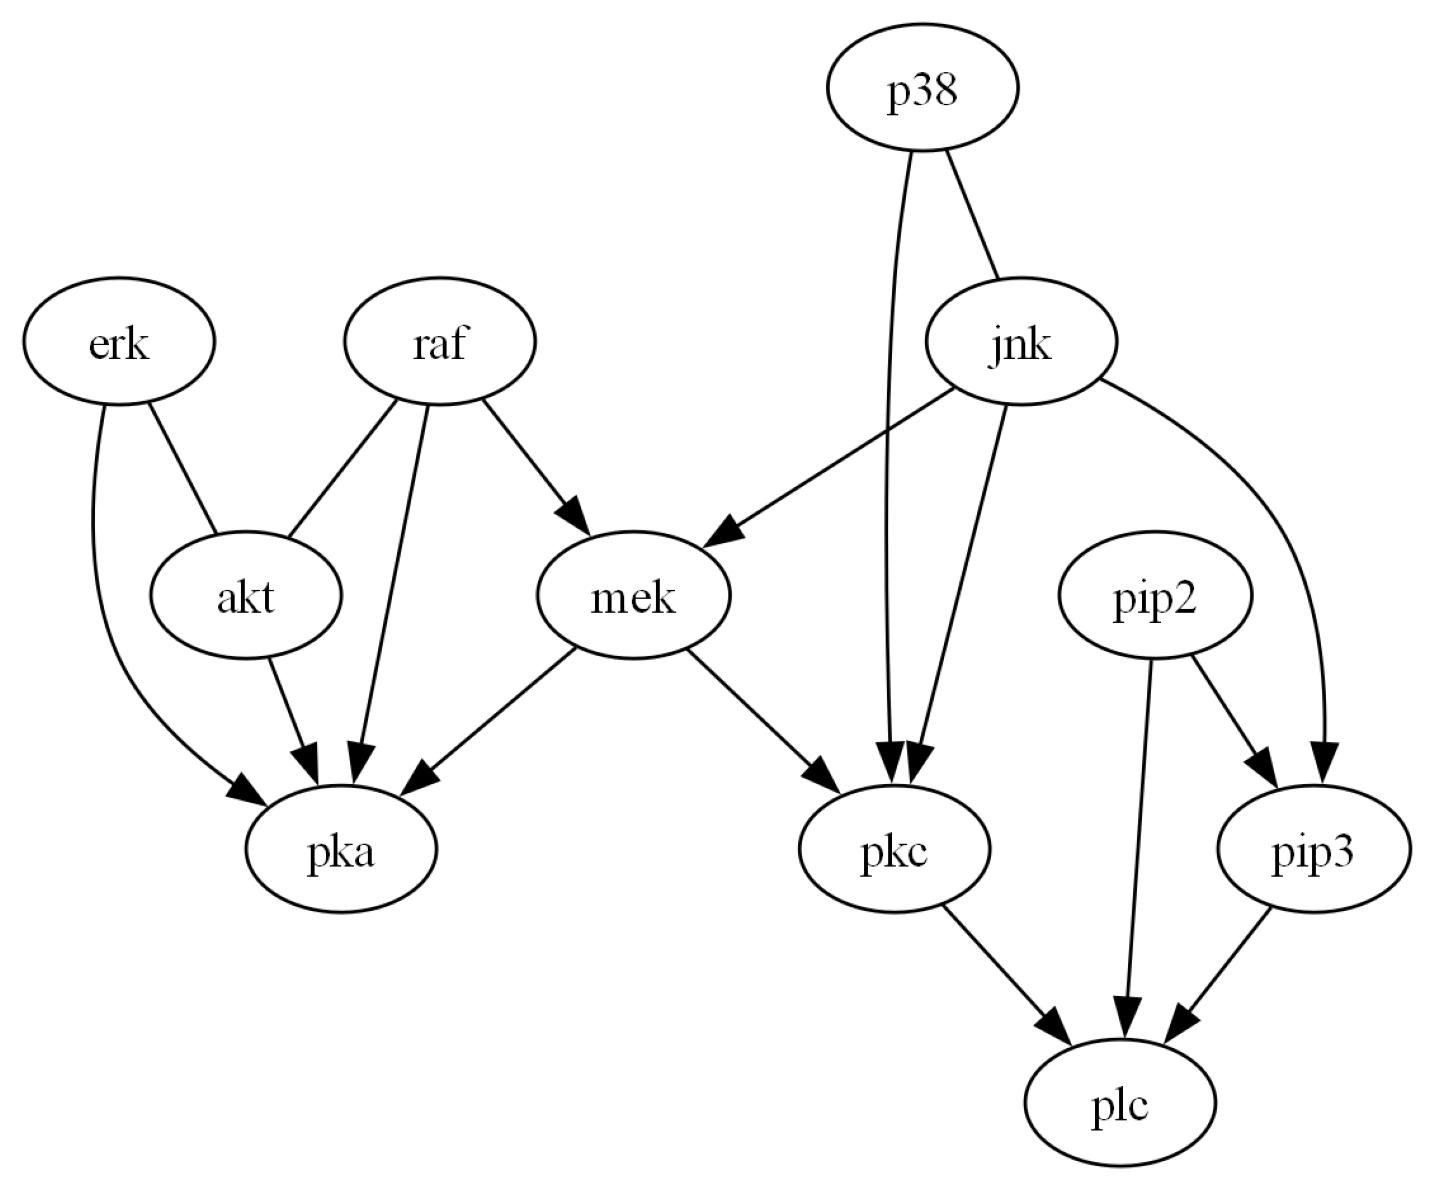

In [ ]:
# Run the PC algorithm with different parameters
try:
    os.remove("cache/sachs_rcit_binned_cache.json")          # raises FileNotFoundError if absent
except FileNotFoundError:
    print("File did not exist.")

start_time = time.monotonic()
cg_rcit = pc(data,
        alpha = 0.05,
        indep_test = "rcit",
        # parameters for the indep_test
        n_components = 1000, # number of components for the RCIT test, <= number of samples
        # end
        cache_path= "cache/sachs_rcit_cache.json", # caching helps
        stable = True,  
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = True,
        show_progress = True,
)
print("\n PC test using RCIT completed.")
end_time = time.monotonic()
print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )


# Visualize using pydot and save the graph
cg_rcit.draw_pydot_graph(labels=labels)
pyd_rcit = GraphUtils.to_pydot(cg_rcit.G, labels=labels)
pyd_rcit.write_png('sach_rcit.png')

# Visualize using networks
# cg_fisherz.to_nx_graph()
# cg_fisherz.draw_nx_graph(skel=False)



In [74]:
# For arrows

est = cg_rcit.G
truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")

adj   = AdjacencyConfusion(truth_cpdag, est)
arrow = ArrowConfusion(truth_cpdag, est)

print(adj)

arrow_stats = {
    "TP"       : arrow.get_arrows_tp(),
    "FP"       : arrow.get_arrows_fp(),
    "FN"       : arrow.get_arrows_fn(),
    #"TN"       : arrow.get_arrows_tn(),
    "Precision": round(arrow.get_arrows_precision(), 3),
    "Recall"   : round(arrow.get_arrows_recall(),    3),
    "F1"       : round(arrow.get_arrows_f1(),        3),
}

adj_stats = {
    "TP"       : adj.get_adj_tp(),
    "FP"       : adj.get_adj_fp(),
    "FN"       : adj.get_adj_fn(),
    #"TN"       : adj.get_adj_tn(),
    "Precision": round(adj.get_adj_precision(), 3),
    "Recall"   : round(adj.get_adj_recall(),    3),
    "F1"       : round(adj.get_adj_f1(),        3),
}

df = pd.DataFrame(
    [adj_stats, arrow_stats], 
    index=["Adjacency", "Arrow‑head"]
).T

#display(df.style.set_sticky()) 
display(df) 

# Structural Hamming Distance
shd = SHD(truth_cpdag, est).get_shd()
print("Structural Hamming Distance:", shd)

,Adjacency,Arrow‑head
TP,6.000,1.000
FP,11.000,13.000
FN,11.000,16.000
Precision,0.353,0.071
Recall,0.353,0.059
F1,0.353,0.065


Structural Hamming Distance: 27


### Simulation IB: Comparing different types of CI test on Binned Synthetic Sach Data

In [22]:
data, labels = load_dataset("sachs")
data = np.loadtxt('tests/TestData/bnlearn_discrete_10000/data/sachs.txt', skiprows=1)
df = pd.DataFrame(np.array(data),columns=labels)

# ------------------------------------------------------------------
# 3.  Standardise (zero mean, unit variance) column‑wise
# ------------------------------------------------------------------
#df_std = (df - df.mean()) / df.std(ddof=0)
#data = df_std.to_numpy(dtype=float)  # Convert the DataFrame to a NumPy array
# df_std is your z‑scored DataFrame
print(df_std.iloc[0:5, :])  # Print the first 5 rows and columns of the z‑scored DataFrame
print(data.shape) # (number of samples, number of variables)
print(labels)  # Labels of the variables


        raf       mek       plc      pip2      pip3       erk       akt  \
0 -0.394616 -0.350584 -0.264792 -0.443731  0.737945 -0.436918 -0.465800   
1 -0.356234 -0.341831 -0.244775 -0.448742 -0.439188 -0.175263 -0.353283   
2 -0.261289 -0.268628 -0.231545 -0.470791 -0.326051 -0.256007 -0.353283   
3 -0.206342 -0.165984 -0.182652 -0.459767 -0.598090 -0.453940 -0.503548   
4 -0.365122 -0.333079 -0.285673 -0.472361 -0.051921 -0.120706 -0.254559   

        pka       pkc       p38       jnk  
0 -0.328605 -0.143669 -0.182147 -0.154269  
1 -0.424816 -0.290443 -0.239551 -0.054569  
2 -0.345675 -0.203972 -0.208423 -0.249332  
3 -0.151701 -0.179205 -0.215094 -0.232638  
4 -0.497751 -0.276552 -0.220955  0.037248  
(10000, 11)
['raf', 'mek', 'plc', 'pip2', 'pip3', 'erk', 'akt', 'pka', 'pkc', 'p38', 'jnk']


#### CI Test: FisherZ

  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using FisherZ completed.

 Computational Time Elapsed:  0.19652019999921322  seconds


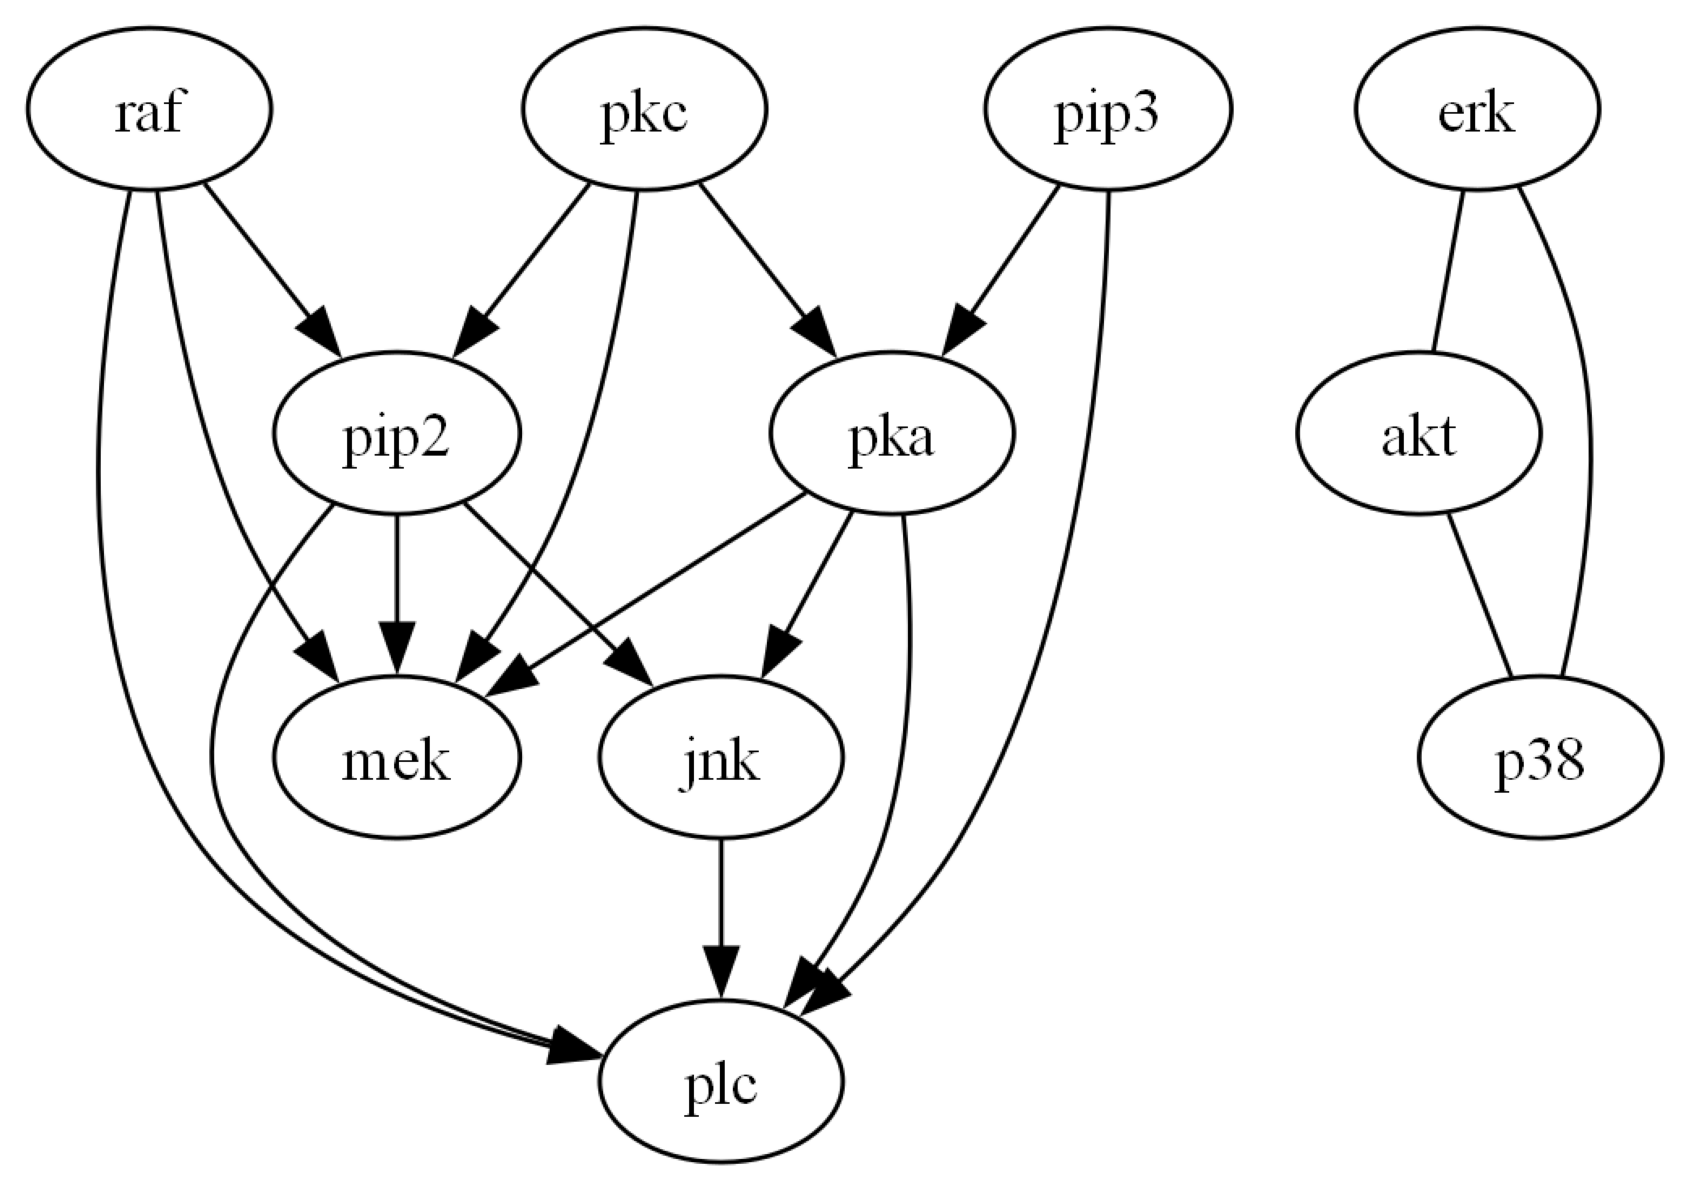

In [ ]:
# Run the PC algorithm with different parameters
start_time = time.monotonic()
cg_fisherz = pc(data,
        alpha = 0.05,
        indep_test = "fisherz",
        # parameters for the indep_test
        # end 
        stable = True,
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = False,
        show_progress = True
)
print("\n PC test using FisherZ completed.")
end_time = time.monotonic()
print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )


# Visualize using pydot and save the graph
cg_fisherz.draw_pydot_graph(labels=labels)
pyd_fisherz = GraphUtils.to_pydot(cg_fisherz.G, labels=labels)
pyd_fisherz.write_png('sach_fisherz_binned.png')



In [9]:
# For arrows

est = cg_fisherz.G
truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")

adj   = AdjacencyConfusion(truth_cpdag, est)
arrow = ArrowConfusion(truth_cpdag, est)

arrow_stats = {
    "TP"       : arrow.get_arrows_tp(),
    "FP"       : arrow.get_arrows_fp(),
    "FN"       : arrow.get_arrows_fn(),
    #"TN"       : arrow.get_arrows_tn(),
    "Precision": round(arrow.get_arrows_precision(), 3),
    "Recall"   : round(arrow.get_arrows_recall(),    3),
    "F1"       : round(arrow.get_arrows_f1(),        3),
}

adj_stats = {
    "TP"       : adj.get_adj_tp(),
    "FP"       : adj.get_adj_fp(),
    "FN"       : adj.get_adj_fn(),
    #"TN"       : adj.get_adj_tn(),
    "Precision": round(adj.get_adj_precision(), 3),
    "Recall"   : round(adj.get_adj_recall(),    3),
    "F1"       : round(adj.get_adj_f1(),        3),
}

df = pd.DataFrame(
    [adj_stats, arrow_stats], 
    index=["Adjacency", "Arrow‑head"]
).T

#display(df.style.set_sticky()) 
display(df) 

# Structural Hamming Distance
shd = SHD(truth_cpdag, est).get_shd()
print("Structural Hamming Distance:", shd)

,Adjacency,Arrow‑head
TP,12.000,6.000
FP,6.000,9.000
FN,5.000,11.000
Precision,0.667,0.400
Recall,0.706,0.353
F1,0.686,0.375


Structural Hamming Distance: 17


#### CI Test: Chi-Squared

  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using chisq completed.

 Computational Time Elapsed:  0.6040764999997918  seconds


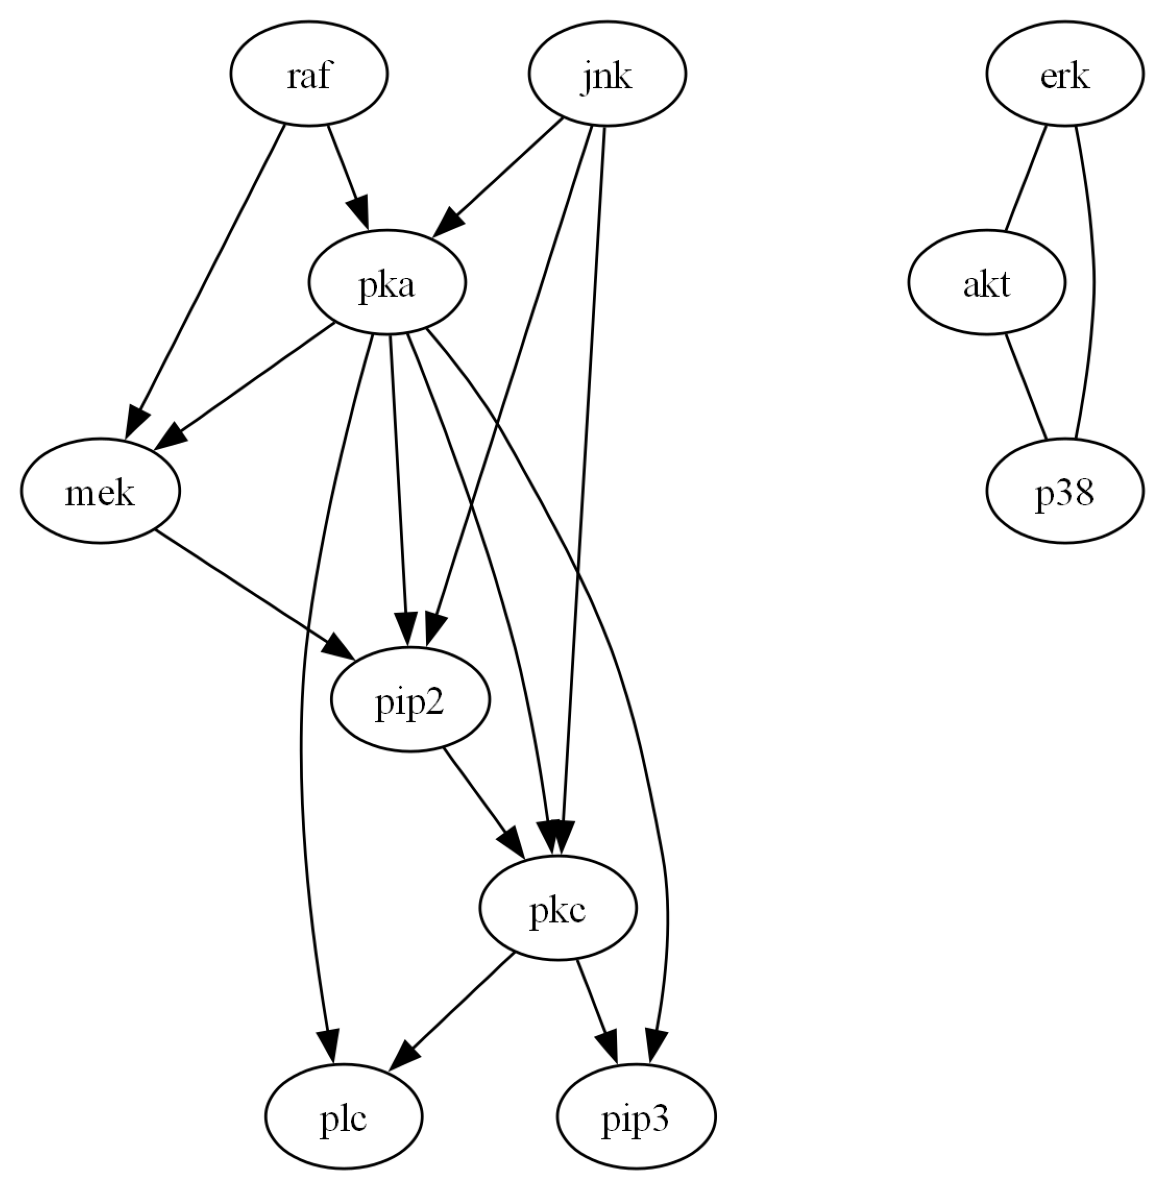

In [10]:
# Run the PC algorithm with different parameters
start_time = time.monotonic()
cg_chisq = pc(data,
        alpha = 0.05,
        indep_test = "chisq",
        # parameters for the indep_test
        # end 
        stable = True,
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = False,
        show_progress = True
)
print("\n PC test using chisq completed.")
end_time = time.monotonic()
print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )


# Visualize using pydot and save the graph
cg_chisq.draw_pydot_graph(labels=labels)
pyd_chisq = GraphUtils.to_pydot(cg_chisq.G, labels=labels)
pyd_chisq.write_png('sach_chisq_binned.png')



In [11]:
# For arrows

est = cg_chisq.G
truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")

adj   = AdjacencyConfusion(truth_cpdag, est)
arrow = ArrowConfusion(truth_cpdag, est)

arrow_stats = {
    "TP"       : arrow.get_arrows_tp(),
    "FP"       : arrow.get_arrows_fp(),
    "FN"       : arrow.get_arrows_fn(),
    #"TN"       : arrow.get_arrows_tn(),
    "Precision": round(arrow.get_arrows_precision(), 3),
    "Recall"   : round(arrow.get_arrows_recall(),    3),
    "F1"       : round(arrow.get_arrows_f1(),        3),
}

adj_stats = {
    "TP"       : adj.get_adj_tp(),
    "FP"       : adj.get_adj_fp(),
    "FN"       : adj.get_adj_fn(),
    #"TN"       : adj.get_adj_tn(),
    "Precision": round(adj.get_adj_precision(), 3),
    "Recall"   : round(adj.get_adj_recall(),    3),
    "F1"       : round(adj.get_adj_f1(),        3),
}

df = pd.DataFrame(
    [adj_stats, arrow_stats], 
    index=["Adjacency", "Arrow‑head"]
).T

#display(df.style.set_sticky()) 
display(df) 

# Structural Hamming Distance
shd = SHD(truth_cpdag, est).get_shd()
print("Structural Hamming Distance:", shd)

,Adjacency,Arrow‑head
TP,17.0,7.000
FP,0.0,7.000
FN,0.0,10.000
Precision,1.0,0.500
Recall,1.0,0.412
F1,1.0,0.452


Structural Hamming Distance: 10


#### CI Test: G-Squared

  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using gsq completed.

 Computational Time Elapsed:  0.5700925999990432  seconds


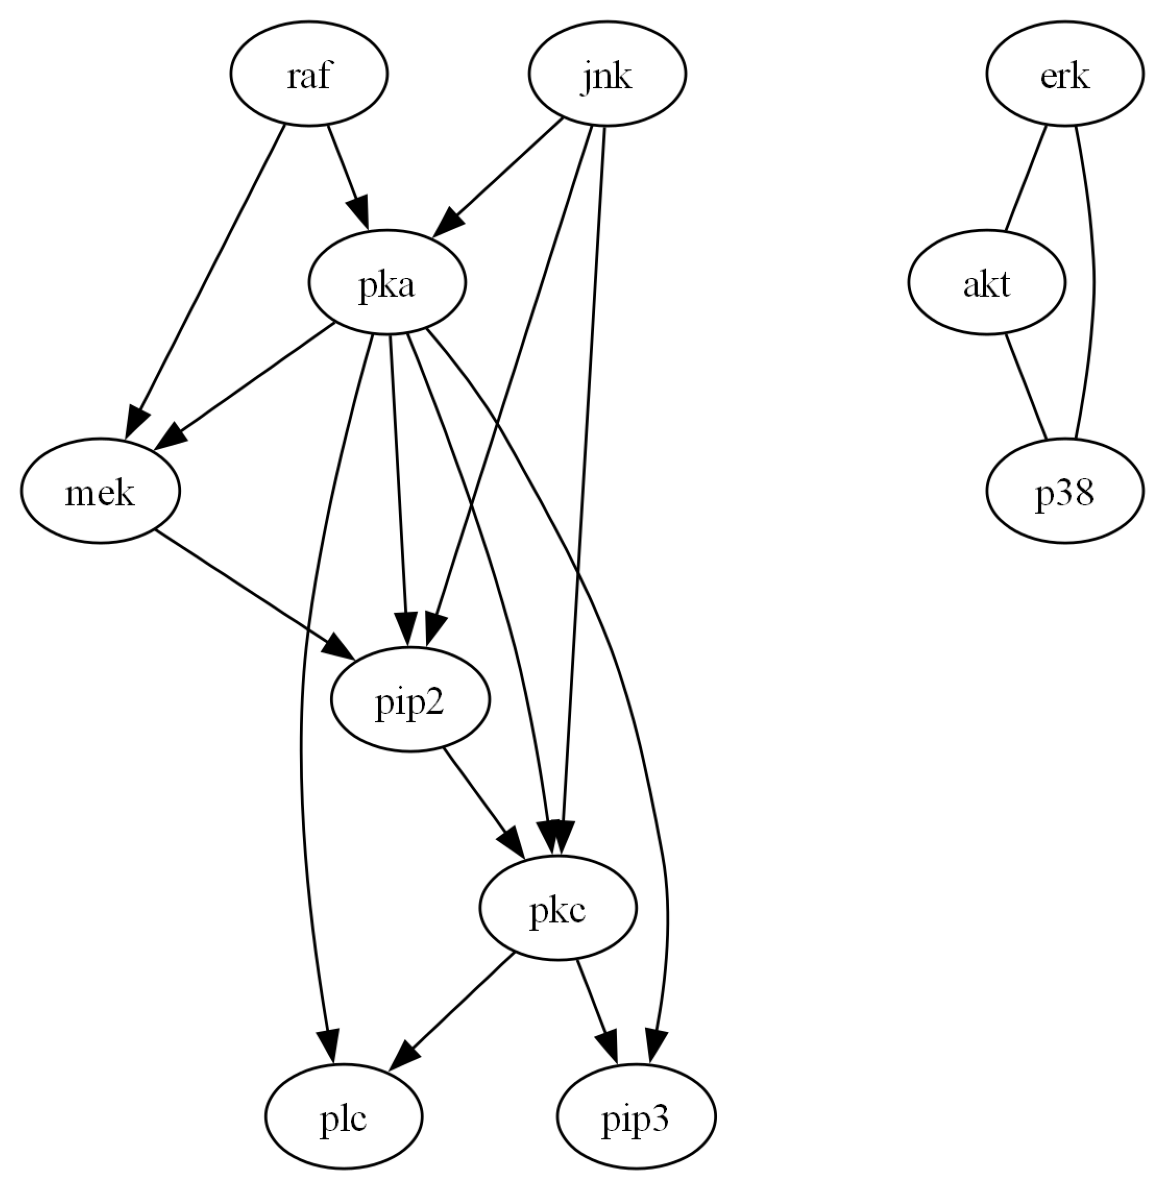

In [12]:
# Run the PC algorithm with different parameters
start_time = time.monotonic()
cg_gsq = pc(data,
        alpha = 0.05,
        indep_test = "gsq",
        # parameters for the indep_test
        # end 
        stable = True,
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = False,
        show_progress = True
)
print("\n PC test using gsq completed.")
end_time = time.monotonic()
print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )


# Visualize using pydot and save the graph
cg_gsq.draw_pydot_graph(labels=labels)
pyd_gsq = GraphUtils.to_pydot(cg_gsq.G, labels=labels)
pyd_gsq.write_png('sach_gsq_binned.png')



In [14]:
# For arrows

est = cg_gsq.G
truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")

adj   = AdjacencyConfusion(truth_cpdag, est)
arrow = ArrowConfusion(truth_cpdag, est)

arrow_stats = {
    "TP"       : arrow.get_arrows_tp(),
    "FP"       : arrow.get_arrows_fp(),
    "FN"       : arrow.get_arrows_fn(),
    #"TN"       : arrow.get_arrows_tn(),
    "Precision": round(arrow.get_arrows_precision(), 3),
    "Recall"   : round(arrow.get_arrows_recall(),    3),
    "F1"       : round(arrow.get_arrows_f1(),        3),
}

adj_stats = {
    "TP"       : adj.get_adj_tp(),
    "FP"       : adj.get_adj_fp(),
    "FN"       : adj.get_adj_fn(),
    #"TN"       : adj.get_adj_tn(),
    "Precision": round(adj.get_adj_precision(), 3),
    "Recall"   : round(adj.get_adj_recall(),    3),
    "F1"       : round(adj.get_adj_f1(),        3),
}

df = pd.DataFrame(
    [adj_stats, arrow_stats], 
    index=["Adjacency", "Arrow‑head"]
).T

#display(df.style.set_sticky()) 
display(df) 

# Structural Hamming Distance
shd = SHD(truth_cpdag, est).get_shd()
print("Structural Hamming Distance:", shd)

,Adjacency,Arrow‑head
TP,17.0,7.000
FP,0.0,7.000
FN,0.0,10.000
Precision,1.0,0.500
Recall,1.0,0.412
F1,1.0,0.452


Structural Hamming Distance: 10


#### CI Test: RCIT

  0%|          | 0/11 [00:00<?, ?it/s]

0 dep 1 | () with p-value 0.000000

0 dep 2 | () with p-value 0.000000

0 dep 3 | () with p-value 0.000000

0 dep 4 | () with p-value 0.000022

0 dep 5 | () with p-value 0.000000

0 dep 6 | () with p-value 0.000000

0 dep 7 | () with p-value 0.000000

0 dep 8 | () with p-value 0.000000

0 dep 9 | () with p-value 0.000000

0 dep 10 | () with p-value 0.000000

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.000000

1 dep 3 | () with p-value 0.000000

1 dep 4 | () with p-value 0.000001

1 dep 5 | () with p-value 0.000000

1 dep 6 | () with p-value 0.000000

1 dep 7 | () with p-value 0.000000

1 dep 8 | () with p-value 0.000000

1 dep 9 | () with p-value 0.000000

1 dep 10 | () with p-value 0.000000

2 dep 0 | () with p-value 0.000000

2 dep 1 | () with p-value 0.000000

2 dep 3 | () with p-value 0.000000

2 dep 4 | () with p-value 0.000000

2 dep 5 | () with p-value 0.000000

2 dep 6 | () with p-value 0.000000

2 dep 7 | () with p-value 0.000000

2 dep 8 | () with p-value 

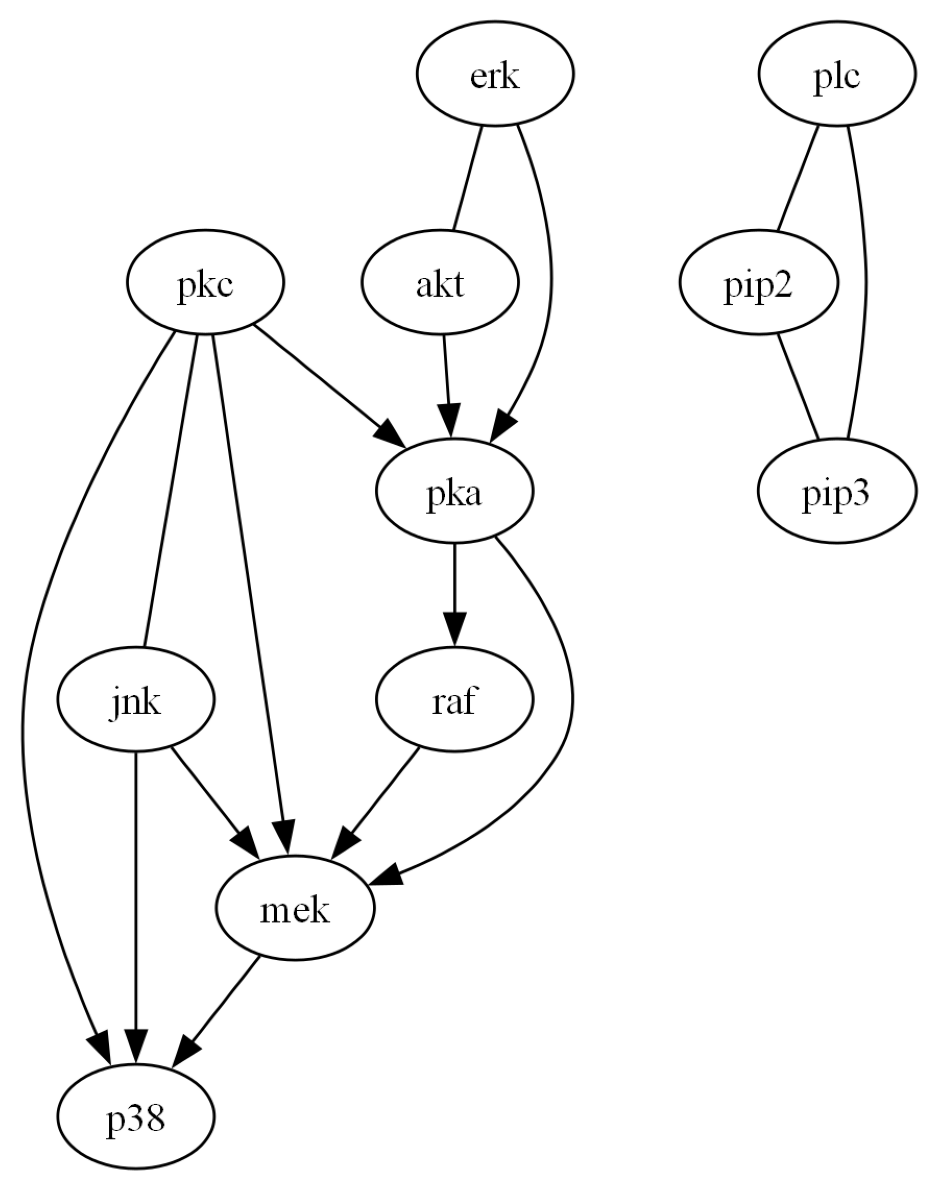

In [26]:
# Run the PC algorithm with different parameters
try:
    os.remove("cache/sachs_rcit_binned_cache.json")          # raises FileNotFoundError if absent
except FileNotFoundError:
    print("File did not exist.")

start_time = time.monotonic()
cg_rcit = pc(data,
        alpha = 0.05,
        indep_test = "rcit",
        # parameters for the indep_test
        n_components = 600, # number of components for the RCIT test, <= number of samples
        # end
        cache_path= "cache/sachs_rcit_binned_cache.json", # caching helps
        stable = True,  
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = True,
        show_progress = True,
)
print("\n PC test using RCIT completed.")
end_time = time.monotonic()
print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )


# Visualize using pydot and save the graph
cg_rcit.draw_pydot_graph(labels=labels)
pyd_rcit = GraphUtils.to_pydot(cg_rcit.G, labels=labels)
pyd_rcit.write_png('sach_rcit_binned.png')

# Visualize using networks
# cg_fisherz.to_nx_graph()
# cg_fisherz.draw_nx_graph(skel=False)



In [27]:
# For arrows

est = cg_rcit.G
truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")

adj   = AdjacencyConfusion(truth_cpdag, est)
arrow = ArrowConfusion(truth_cpdag, est)

print(adj)

arrow_stats = {
    "TP"       : arrow.get_arrows_tp(),
    "FP"       : arrow.get_arrows_fp(),
    "FN"       : arrow.get_arrows_fn(),
    #"TN"       : arrow.get_arrows_tn(),
    "Precision": round(arrow.get_arrows_precision(), 3),
    "Recall"   : round(arrow.get_arrows_recall(),    3),
    "F1"       : round(arrow.get_arrows_f1(),        3),
}

adj_stats = {
    "TP"       : adj.get_adj_tp(),
    "FP"       : adj.get_adj_fp(),
    "FN"       : adj.get_adj_fn(),
    #"TN"       : adj.get_adj_tn(),
    "Precision": round(adj.get_adj_precision(), 3),
    "Recall"   : round(adj.get_adj_recall(),    3),
    "F1"       : round(adj.get_adj_f1(),        3),
}

df = pd.DataFrame(
    [adj_stats, arrow_stats], 
    index=["Adjacency", "Arrow‑head"]
).T

#display(df.style.set_sticky()) 
display(df) 

# Structural Hamming Distance
shd = SHD(truth_cpdag, est).get_shd()
print("Structural Hamming Distance:", shd)

,Adjacency,Arrow‑head
TP,6.000,3.000
FP,10.000,8.000
FN,11.000,14.000
Precision,0.375,0.273
Recall,0.353,0.176
F1,0.364,0.214


Structural Hamming Distance: 24


### Simulation IC: Comparing different types of CI test on Binned Experimental Sach Data

In [14]:
## Recall that df is the imported experimental dataframe

def bin_by_quantiles(df: pd.DataFrame, k: int) -> pd.DataFrame:
    """
    Replace each numeric column in `df` by its quantile bins (1 … k).
    
    Parameters
    ----------
    df : pd.DataFrame
        Input frame, shape (n_rows, n_features).  Only numeric dtypes are binned;
        non‑numeric columns are copied through unchanged.
    k : int, default 4
        Number of quantile bins.  k = 4 → quartiles, k = 10 → deciles, etc.
    suffix : str, default "_bin"
        Append this to the original column name.  Set to "" to overwrite in place.

    Returns
    -------
    pd.DataFrame
        A new DataFrame whose numeric columns are integers 1 … k.
    """
    if k < 2:
        raise ValueError("k must be at least 2 for binning")

    out = df.copy()

    for col in df:
        if np.issubdtype(df[col].dtype, np.number):
            # qcut builds k equal‑frequency buckets, labels start at 1
            out[col] = pd.qcut(
                df[col],
                q=k,
                labels=range(1, k + 1),
                duplicates="drop",   # drop if too many ties in small data sets
            ).astype(int) 
        # else: keep non‑numeric column unchanged

    return out

# Toy data -----------------------------------------------------------
np.random.seed(0)
df_raw = pd.DataFrame({
    "A": np.random.randn(10),
    "B": np.random.rand(10) * 100,
    "city": list("AABBCCDDEE")          # non‑numeric column
})

# Bin into quartiles -------------------------------------------------
df_binned = bin_by_quantiles(df_raw, k=4)
print(df_binned)


   A  B city
0  4  3    A
1  2  2    A
2  3  2    B
3  4  4    B
4  4  1    C
5  1  1    C
6  3  1    D
7  1  4    D
8  1  3    E
9  2  4    E


In [15]:
data, labels = load_dataset("sachs")
df = pd.DataFrame(np.array(data),columns=labels)

# ------------------------------------------------------------------
# 3.  Standardise (zero mean, unit variance) column‑wise
# ------------------------------------------------------------------
df_binned = bin_by_quantiles(df, k=4)
data = df_binned.to_numpy(dtype=int)  # Convert the DataFrame to a NumPy array
# df_std is your z‑scored DataFrame
print(df_binned.iloc[0:5, :])  # Print the first 5 rows and columns of the z‑scored DataFrame
print(data.shape) # (number of samples, number of variables)
print(labels)  # Labels of the variables


   raf  mek  plc  pip2  pip3  erk  akt  pka  pkc  p38  jnk
0    1    1    1     1     4    1    1    2    3    3    3
1    2    1    2     1     1    3    2    2    1    1    4
2    3    3    2     1     2    2    2    2    2    3    3
3    3    4    3     1     1    1    1    3    3    2    3
4    2    2    1     1     3    3    3    2    2    2    4
(7466, 11)
['raf', 'mek', 'plc', 'pip2', 'pip3', 'erk', 'akt', 'pka', 'pkc', 'p38', 'jnk']


In [21]:
def test_all_at_k(df: pd.DataFrame, k: int):
    """
    Test all the independence tests at once.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input frame, shape (n_rows, n_features).  Only numeric dtypes are binned;
        non‑numeric columns are copied through unchanged.
    k : int, default 4
        Number of quantile bins.  k = 4 → quartiles, k = 10 → deciles, etc.

    Prints
    ----------
    The results of the independence tests for that value of k.
    """ 
    print("\n\nTesting all at k =", k)
    print("=========================================")
    df_binned = bin_by_quantiles(df, k)
    data = df_binned.to_numpy(dtype=int) 

    ### FisherZ

    print("\n\nFisherZ test")

    start_time = time.monotonic()
    cg_fisherz = pc(data,
        alpha = 0.05,
        indep_test = "fisherz",
        # parameters for the indep_test
        # end 
        stable = True,
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = False,
        show_progress = True
    )
    print("\n PC test using FisherZ completed.")
    end_time = time.monotonic()
    print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )

    est = cg_fisherz.G
    truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")

    adj   = AdjacencyConfusion(truth_cpdag, est)
    arrow = ArrowConfusion(truth_cpdag, est)

    arrow_stats = {
        "TP"       : arrow.get_arrows_tp(),
        "FP"       : arrow.get_arrows_fp(),
        "FN"       : arrow.get_arrows_fn(),
        #"TN"       : arrow.get_arrows_tn(),
        "Precision": round(arrow.get_arrows_precision(), 3),
        "Recall"   : round(arrow.get_arrows_recall(),    3),
        "F1"       : round(arrow.get_arrows_f1(),        3),
    }

    adj_stats = {
        "TP"       : adj.get_adj_tp(),
        "FP"       : adj.get_adj_fp(),
        "FN"       : adj.get_adj_fn(),
        #"TN"       : adj.get_adj_tn(),
        "Precision": round(adj.get_adj_precision(), 3),
        "Recall"   : round(adj.get_adj_recall(),    3),
        "F1"       : round(adj.get_adj_f1(),        3),
    }

    df_error = pd.DataFrame(
        [adj_stats, arrow_stats], 
        index=["Adjacency", "Arrow‑head"]
    ).T

    display(df_error) 

    # Structural Hamming Distance
    shd = SHD(truth_cpdag, est).get_shd()
    print("Structural Hamming Distance:", shd)

    ### RCIT
    print("\n\nRCIT test")
    try:
        os.remove("cache/sachs_rcit_binned_cache.json")          # raises FileNotFoundError if absent
    except FileNotFoundError:
        print("File did not exist.")
    start_time = time.monotonic()
    cg_rcit = pc(data,
        alpha = 0.05,
        indep_test = "rcit",
        # parameters for the indep_test
        n_components = 600, # number of components for the RCIT test, <= number of samples
        # end
        cache_path= "cache/sachs_rcit_binned_cache.json", # caching helps
        stable = True,  
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = False,
        show_progress = True,
    )

    print("\n PC test using RCIT completed.")
    end_time = time.monotonic()
    print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )
    est = cg_rcit.G
    truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")
    adj   = AdjacencyConfusion(truth_cpdag, est)
    arrow = ArrowConfusion(truth_cpdag, est)

    arrow_stats = {
        "TP"       : arrow.get_arrows_tp(),
        "FP"       : arrow.get_arrows_fp(),
        "FN"       : arrow.get_arrows_fn(),
        #"TN"       : arrow.get_arrows_tn(),
        "Precision": round(arrow.get_arrows_precision(), 3),
        "Recall"   : round(arrow.get_arrows_recall(),    3),
        "F1"       : round(arrow.get_arrows_f1(),        3),
    }
    adj_stats = {
        "TP"       : adj.get_adj_tp(),
        "FP"       : adj.get_adj_fp(),
        "FN"       : adj.get_adj_fn(),
        #"TN"       : adj.get_adj_tn(),
        "Precision": round(adj.get_adj_precision(), 3),
        "Recall"   : round(adj.get_adj_recall(),    3),
        "F1"       : round(adj.get_adj_f1(),        3),
    }
    df_error = pd.DataFrame(
        [adj_stats, arrow_stats], 
        index=["Adjacency", "Arrow‑head"]
    ).T

    display(df_error)
    # Structural Hamming Distance
    shd = SHD(truth_cpdag, est).get_shd()
    print("Structural Hamming Distance:", shd)

    ### Chisq
    print("\n\nChisq test")
    start_time = time.monotonic()
    cg_chisq = pc(data,
        alpha = 0.05,
        indep_test = "chisq",
        # parameters for the indep_test
        # end 
        stable = True,
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = False,
        show_progress = True
    )
    print("\n PC test using chisq completed.")
    end_time = time.monotonic()
    print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )
    est = cg_chisq.G
    truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")
    adj   = AdjacencyConfusion(truth_cpdag, est)
    arrow = ArrowConfusion(truth_cpdag, est)
    arrow_stats = {
        "TP"       : arrow.get_arrows_tp(),
        "FP"       : arrow.get_arrows_fp(),
        "FN"       : arrow.get_arrows_fn(),
        #"TN"       : arrow.get_arrows_tn(),
        "Precision": round(arrow.get_arrows_precision(), 3),
        "Recall"   : round(arrow.get_arrows_recall(),    3),
        "F1"       : round(arrow.get_arrows_f1(),        3),
    }
    adj_stats = {
        "TP"       : adj.get_adj_tp(),
        "FP"       : adj.get_adj_fp(),
        "FN"       : adj.get_adj_fn(),
        #"TN"       : adj.get_adj_tn(),
        "Precision": round(adj.get_adj_precision(), 3),
        "Recall"   : round(adj.get_adj_recall(),    3),
        "F1"       : round(adj.get_adj_f1(),        3),
    }
    df_error = pd.DataFrame(
        [adj_stats, arrow_stats], 
        index=["Adjacency", "Arrow‑head"]
    ).T
    display(df_error)
    # Structural Hamming Distance
    shd = SHD(truth_cpdag, est).get_shd()
    print("Structural Hamming Distance:", shd)

    ### Gsq
    print("\n\nGsq test")
    start_time = time.monotonic()
    cg_gsq = pc(data,
        alpha = 0.05,
        indep_test = "gsq",
        # parameters for the indep_test
        # end 
        stable = True,
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = False,
        show_progress = True
    )
    print("\n PC test using gsq completed.")
    end_time = time.monotonic()
    print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )
    est = cg_gsq.G
    truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")
    adj   = AdjacencyConfusion(truth_cpdag, est)
    arrow = ArrowConfusion(truth_cpdag, est)
    arrow_stats = {
        "TP"       : arrow.get_arrows_tp(),
        "FP"       : arrow.get_arrows_fp(),
        "FN"       : arrow.get_arrows_fn(),
        #"TN"       : arrow.get_arrows_tn(),
        "Precision": round(arrow.get_arrows_precision(), 3),
        "Recall"   : round(arrow.get_arrows_recall(),    3),
        "F1"       : round(arrow.get_arrows_f1(),        3),
    }
    adj_stats = {
        "TP"       : adj.get_adj_tp(),
        "FP"       : adj.get_adj_fp(),
        "FN"       : adj.get_adj_fn(),
        #"TN"       : adj.get_adj_tn(),
        "Precision": round(adj.get_adj_precision(), 3),
        "Recall"   : round(adj.get_adj_recall(),    3),
        "F1"       : round(adj.get_adj_f1(),        3),
    }
    df_error = pd.DataFrame(
        [adj_stats, arrow_stats], 
        index=["Adjacency", "Arrow‑head"]
    ).T
    display(df_error)
    # Structural Hamming Distance
    shd = SHD(truth_cpdag, est).get_shd()
    print("Structural Hamming Distance:", shd)


test_all_at_k(df, 3)
test_all_at_k(df, 4)
test_all_at_k(df, 5)
test_all_at_k(df, 6)
test_all_at_k(df, 10)



Testing all at k = 3


FisherZ test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using FisherZ completed.

 Computational Time Elapsed:  0.38258430000860244  seconds


,Adjacency,Arrow‑head
TP,10.000,7.000
FP,17.000,19.000
FN,7.000,10.000
Precision,0.370,0.269
Recall,0.588,0.412
F1,0.455,0.326


Structural Hamming Distance: 27


RCIT test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using RCIT completed.

 Computational Time Elapsed:  338.6456511000288  seconds


,Adjacency,Arrow‑head
TP,6.000,2.000
FP,14.000,17.000
FN,11.000,15.000
Precision,0.300,0.105
Recall,0.353,0.118
F1,0.324,0.111


Structural Hamming Distance: 29


Chisq test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using chisq completed.

 Computational Time Elapsed:  7.134372900007293  seconds


,Adjacency,Arrow‑head
TP,12.000,9.000
FP,26.000,28.000
FN,5.000,8.000
Precision,0.316,0.243
Recall,0.706,0.529
F1,0.436,0.333


Structural Hamming Distance: 34


Gsq test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using gsq completed.

 Computational Time Elapsed:  8.470307699986733  seconds


,Adjacency,Arrow‑head
TP,15.000,9.000
FP,29.000,32.000
FN,2.000,8.000
Precision,0.341,0.220
Recall,0.882,0.529
F1,0.492,0.310


Structural Hamming Distance: 37


Testing all at k = 4


FisherZ test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using FisherZ completed.

 Computational Time Elapsed:  0.3153399999719113  seconds


,Adjacency,Arrow‑head
TP,9.000,5.000
FP,14.000,15.000
FN,8.000,12.000
Precision,0.391,0.250
Recall,0.529,0.294
F1,0.450,0.270


Structural Hamming Distance: 26


RCIT test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using RCIT completed.

 Computational Time Elapsed:  343.21722930000396  seconds


,Adjacency,Arrow‑head
TP,4.000,2.000
FP,17.000,15.000
FN,13.000,15.000
Precision,0.190,0.118
Recall,0.235,0.118
F1,0.211,0.118


Structural Hamming Distance: 32


Chisq test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using chisq completed.

 Computational Time Elapsed:  7.46753250004258  seconds


,Adjacency,Arrow‑head
TP,12.000,9.000
FP,26.000,26.000
FN,5.000,8.000
Precision,0.316,0.257
Recall,0.706,0.529
F1,0.436,0.346


Structural Hamming Distance: 34


Gsq test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using gsq completed.

 Computational Time Elapsed:  13.83917749999091  seconds


,Adjacency,Arrow‑head
TP,15.000,10.000
FP,29.000,31.000
FN,2.000,7.000
Precision,0.341,0.244
Recall,0.882,0.588
F1,0.492,0.345


Structural Hamming Distance: 36


Testing all at k = 5


FisherZ test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using FisherZ completed.

 Computational Time Elapsed:  0.30942820000927895  seconds


,Adjacency,Arrow‑head
TP,9.000,4.000
FP,15.000,17.000
FN,8.000,13.000
Precision,0.375,0.190
Recall,0.529,0.235
F1,0.439,0.211


Structural Hamming Distance: 28


RCIT test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using RCIT completed.

 Computational Time Elapsed:  390.1752102000173  seconds


,Adjacency,Arrow‑head
TP,4.000,2.000
FP,15.000,14.000
FN,13.000,15.000
Precision,0.211,0.125
Recall,0.235,0.118
F1,0.222,0.121


Structural Hamming Distance: 30


Chisq test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using chisq completed.

 Computational Time Elapsed:  18.259876399999484  seconds


,Adjacency,Arrow‑head
TP,11.000,7.000
FP,25.000,20.000
FN,6.000,10.000
Precision,0.306,0.259
Recall,0.647,0.412
F1,0.415,0.318


Structural Hamming Distance: 35


Gsq test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using gsq completed.

 Computational Time Elapsed:  48.444599299982656  seconds


,Adjacency,Arrow‑head
TP,15.000,7.000
FP,31.000,30.000
FN,2.000,10.000
Precision,0.326,0.189
Recall,0.882,0.412
F1,0.476,0.259


Structural Hamming Distance: 41


Testing all at k = 6


FisherZ test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using FisherZ completed.

 Computational Time Elapsed:  0.43092369998339564  seconds


,Adjacency,Arrow‑head
TP,9.000,5.000
FP,15.000,17.000
FN,8.000,12.000
Precision,0.375,0.227
Recall,0.529,0.294
F1,0.439,0.256


Structural Hamming Distance: 27


RCIT test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using RCIT completed.

 Computational Time Elapsed:  350.0791609000298  seconds


,Adjacency,Arrow‑head
TP,4.000,3.000
FP,15.000,15.000
FN,13.000,14.000
Precision,0.211,0.167
Recall,0.235,0.176
F1,0.222,0.171


Structural Hamming Distance: 29


Chisq test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using chisq completed.

 Computational Time Elapsed:  35.436021799978334  seconds


,Adjacency,Arrow‑head
TP,11.000,7.000
FP,24.000,26.000
FN,6.000,10.000
Precision,0.314,0.212
Recall,0.647,0.412
F1,0.423,0.280


Structural Hamming Distance: 34


Gsq test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using gsq completed.

 Computational Time Elapsed:  80.42607739998493  seconds


,Adjacency,Arrow‑head
TP,14.000,8.000
FP,30.000,32.000
FN,3.000,9.000
Precision,0.318,0.200
Recall,0.824,0.471
F1,0.459,0.281


Structural Hamming Distance: 39


Testing all at k = 10


FisherZ test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using FisherZ completed.

 Computational Time Elapsed:  0.39513640000950545  seconds


,Adjacency,Arrow‑head
TP,9.000,3.000
FP,12.000,14.000
FN,8.000,14.000
Precision,0.429,0.176
Recall,0.529,0.176
F1,0.474,0.176


Structural Hamming Distance: 26


RCIT test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using RCIT completed.

 Computational Time Elapsed:  360.57561759999953  seconds


,Adjacency,Arrow‑head
TP,4.000,4.000
FP,17.000,16.000
FN,13.000,13.000
Precision,0.190,0.200
Recall,0.235,0.235
F1,0.211,0.216


Structural Hamming Distance: 30


Chisq test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using chisq completed.

 Computational Time Elapsed:  68.29574430000503  seconds


,Adjacency,Arrow‑head
TP,12.000,8.000
FP,19.000,20.000
FN,5.000,9.000
Precision,0.387,0.286
Recall,0.706,0.471
F1,0.500,0.356


Structural Hamming Distance: 28


Gsq test


  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using gsq completed.

 Computational Time Elapsed:  2.553174000000581  seconds


c:\Users\hktan\OneDrive - University of California\Codes\Causal-Discovery-for-Financial-Applications\causallearn\graph\ArrowConfusion.py:92: RuntimeWarning: invalid value encountered in scalar divide
  return self.__arrowsTp / (self.__arrowsTp + self.__arrowsFp)


,Adjacency,Arrow‑head
TP,2.000,0.0
FP,5.000,0.0
FN,15.000,17.0
Precision,0.286,NaN
Recall,0.118,0.0
F1,0.167,NaN


Structural Hamming Distance: 22


### Synthetic Data Set

In [ ]:
import unittest

import numpy as np

import causallearn.utils.cit as cit


# TODO : Design more comprehensive test cases, including: design dataset of corner cases.
class TestCIT_KCI(unittest.TestCase):
    print("Testing CIT_KCI...")
    print("Testing Gaussian Dist...")
    def test_Gaussian_dist(self):
        np.random.seed(10)
        X = np.random.randn(300, 1)
        X_prime = np.random.randn(300, 1)
        Y = X + 0.5 * np.random.randn(300, 1)
        Z = Y + 0.5 * np.random.randn(300, 1)
        data = np.hstack((X, X_prime, Y, Z))

        pvalue01 = []
        pvalue03 = []
        pvalue032 = []
        for kernelname in ['Gaussian', 'Polynomial', 'Linear']:
            for est_width in ['empirical', 'median', 'manual']:
                for kwidth in [0.5, 1.0, 2.0]:
                    for use_gp in [True, False]:
                        for approx in [True, False]:
                            for polyd in [1, 2]:
                                cit_CIT = cit.CIT(data, 'kci', kernelX=kernelname, kernelY=kernelname,
                                                  kernelZ=kernelname, est_width=est_width, use_gp=use_gp, approx=approx,
                                                  polyd=polyd, kwidthx=kwidth, kwidthy=kwidth, kwidthz=kwidth)
                                pvalue01.append(round(cit_CIT(0, 1), 4))
                                # X and X_prime are independent, pvalue01 should be expected larger than 0.01
                                pvalue03.append(round(cit_CIT(0, 3), 4))
                                # X and Z are dependent, pvalue03 should be expected smaller than 0.01
                                pvalue032.append(round(cit_CIT(0, 3, {2}), 4))
                                # X and Z are independent conditional on Y, pvalue032 should be expected larger than
                                # 0.01
        pvalue01_truth = [0.5404, 0.5404, 0.507, 0.501, 0.5404, 0.5404, 0.516, 0.536, 0.5404, 0.5404, 0.506, 0.517,
                          0.5404, 0.5404, 0.526, 0.526, 0.5404, 0.5404, 0.492, 0.507, 0.5404, 0.5404, 0.529, 0.511,
                          0.6106, 0.6106, 0.633, 0.594, 0.6106, 0.6106, 0.612, 0.59, 0.6106, 0.6106, 0.595, 0.59,
                          0.6106, 0.6106, 0.606, 0.589, 0.6106, 0.6106, 0.616, 0.587, 0.6106, 0.6106, 0.595, 0.596,
                          0.5404, 0.5404, 0.522, 0.501, 0.5404, 0.5404, 0.524, 0.53, 0.5864, 0.5864, 0.574, 0.574,
                          0.5864, 0.5864, 0.575, 0.603, 0.4901, 0.4901, 0.487, 0.463, 0.4901, 0.4901, 0.47, 0.493,
                          0.2745, 0.1613, 0.251, 0.167, 0.2745, 0.1613, 0.274, 0.15, 0.2745, 0.1613, 0.272, 0.143,
                          0.2745, 0.1613, 0.276, 0.158, 0.2745, 0.1613, 0.272, 0.149, 0.2745, 0.1613, 0.268, 0.142,
                          0.2745, 0.1613, 0.279, 0.141, 0.2745, 0.1613, 0.279, 0.166, 0.2745, 0.1613, 0.26, 0.152,
                          0.2745, 0.1613, 0.27, 0.16, 0.2745, 0.1613, 0.262, 0.145, 0.2745, 0.1613, 0.291, 0.154,
                          0.2745, 0.1613, 0.254, 0.14, 0.2745, 0.1613, 0.253, 0.16, 0.2745, 0.1613, 0.272, 0.17,
                          0.2745, 0.1613, 0.268, 0.168, 0.2745, 0.1613, 0.285, 0.165, 0.2745, 0.1613, 0.276, 0.147,
                          0.2745, 0.2745, 0.274, 0.272, 0.2745, 0.2745, 0.279, 0.277, 0.2745, 0.2745, 0.299, 0.28,
                          0.2745, 0.2745, 0.263, 0.258, 0.2745, 0.2745, 0.258, 0.269, 0.2745, 0.2745, 0.289, 0.295,
                          0.2745, 0.2745, 0.294, 0.283, 0.2745, 0.2745, 0.286, 0.272, 0.2745, 0.2745, 0.267, 0.273,
                          0.2745, 0.2745, 0.27, 0.276, 0.2745, 0.2745, 0.257, 0.269, 0.2745, 0.2745, 0.274, 0.264,
                          0.2745, 0.2745, 0.249, 0.302, 0.2745, 0.2745, 0.282, 0.259, 0.2745, 0.2745, 0.262, 0.265,
                          0.2745, 0.2745, 0.244, 0.264, 0.2745, 0.2745, 0.295, 0.275, 0.2745, 0.2745, 0.261, 0.265]
        pvalue03_truth = [0.0] * (3 * 3 * 3 * 2 * 2 * 2)
        pvalue032_truth = [0.6087, 0.6087, 0.5956, 0.6, 0.5807, 0.5807, 0.583, 0.5612, 0.6087, 0.6087, 0.5952, 0.5918,
                           0.5807, 0.5807, 0.567, 0.5744, 0.6087, 0.6087, 0.5944, 0.6074, 0.5807, 0.5807, 0.5878,
                           0.5558, 0.6164, 0.6164, 0.6252, 0.628, 0.6179, 0.6179, 0.6158, 0.6076, 0.6164, 0.6164,
                           0.617, 0.6208, 0.6179, 0.6179, 0.6152, 0.6154, 0.6164, 0.6164, 0.6108, 0.6196, 0.6179,
                           0.6179, 0.6384, 0.6198, 0.729, 0.729, 0.7334, 0.7246, 0.6899, 0.6899, 0.6918, 0.6874,
                           0.6079, 0.6079, 0.6016, 0.6068, 0.5938, 0.5938, 0.598, 0.5752, 0.571, 0.571, 0.5638,
                           0.5714, 0.5737, 0.5737, 0.5702, 0.5608, 0.9111, 0.247, 0.9098, 0.2272, 0.9111, 0.247,
                           0.9048, 0.2262, 0.9111, 0.247, 0.9106, 0.2488, 0.9111, 0.247, 0.9106, 0.2312, 0.9111,
                           0.247, 0.9122, 0.224, 0.9111, 0.247, 0.9224, 0.2218, 0.9111, 0.247, 0.9148, 0.222, 0.9111,
                           0.247, 0.9082, 0.216, 0.9111, 0.247, 0.9154, 0.2294, 0.9111, 0.247, 0.9024, 0.2218, 0.9111,
                           0.247, 0.9142, 0.2224, 0.9111, 0.247, 0.9178, 0.2292, 0.9111, 0.247, 0.9098, 0.23, 0.9111,
                           0.247, 0.9192, 0.224, 0.9111, 0.247, 0.9066, 0.2316, 0.9111, 0.247, 0.917, 0.2302, 0.9111,
                           0.247, 0.9134, 0.2392, 0.9111, 0.247, 0.912, 0.2376, 0.9111, 0.9111, 0.8996, 0.9074, 0.9111,
                           0.9111, 0.9124, 0.915, 0.9111, 0.9111, 0.9102, 0.9106, 0.9111, 0.9111, 0.912, 0.9082,
                           0.9111, 0.9111, 0.9134, 0.9104, 0.9111, 0.9111, 0.9196, 0.9114, 0.9111, 0.9111, 0.908,
                           0.912, 0.9111, 0.9111, 0.9114, 0.9116, 0.9111, 0.9111, 0.9074, 0.9066, 0.9111, 0.9111,
                           0.9062, 0.9116, 0.9111, 0.9111, 0.9156, 0.907, 0.9111, 0.9111, 0.9116, 0.9078, 0.9111,
                           0.9111, 0.9052, 0.916, 0.9111, 0.9111, 0.912, 0.9098, 0.9111, 0.9111, 0.9068, 0.9162,
                           0.9111, 0.9111, 0.9098, 0.9098, 0.9111, 0.9111, 0.9132, 0.9136, 0.9111, 0.9111, 0.9136,
                           0.9118]
        self.assertEqual(pvalue01, pvalue01_truth)
        self.assertEqual(pvalue03, pvalue03_truth)
        self.assertEqual(pvalue032, pvalue032_truth)

    print("Testing Exp Dist...")
    def test_Exponential_dist(self):
        np.random.seed(10)
        X = np.random.exponential(size=(300, 1))
        X_prime = np.random.exponential(size=(300, 1))
        Y = X + 0.5 * np.random.exponential(size=(300, 1))
        Z = Y + 0.5 * np.random.exponential(size=(300, 1))
        data = np.hstack((X, X_prime, Y, Z))

        pvalue01 = []
        pvalue03 = []
        pvalue032 = []
        for kernelname in ['Gaussian', 'Polynomial', 'Linear']:
            for est_width in ['empirical', 'median', 'manual']:
                for kwidth in [0.5, 1.0, 2.0]:
                    for use_gp in [True, False]:
                        for approx in [True, False]:
                            for polyd in [1, 2]:
                                cit_CIT = cit.CIT(data, 'kci', kernelX=kernelname, kernelY=kernelname,
                                                  kernelZ=kernelname, est_width=est_width, use_gp=use_gp, approx=approx,
                                                  polyd=polyd, kwidthx=kwidth, kwidthy=kwidth, kwidthz=kwidth)
                                pvalue01.append(round(cit_CIT(0, 1), 4))
                                # X and X_prime are independent, pvalue01 should be expected larger than 0.01
                                pvalue03.append(round(cit_CIT(0, 3), 4))
                                # X and Z are dependent, pvalue03 should be expected smaller than 0.01
                                pvalue032.append(round(cit_CIT(0, 3, {2}), 4))
                                # X and Z are independent conditional on Y, pvalue032 should be expected larger than
                                # 0.01
        pvalue01_truth = [0.8513, 0.8513, 0.872, 0.873, 0.8513, 0.8513, 0.871, 0.897, 0.8513, 0.8513, 0.879, 0.886,
                          0.8513, 0.8513, 0.889, 0.891, 0.8513, 0.8513, 0.872, 0.876, 0.8513, 0.8513, 0.853, 0.866,
                          0.5809, 0.5809, 0.573, 0.568, 0.5809, 0.5809, 0.548, 0.571, 0.5809, 0.5809, 0.593, 0.588,
                          0.5809, 0.5809, 0.577, 0.577, 0.5809, 0.5809, 0.581, 0.57, 0.5809, 0.5809, 0.596, 0.598,
                          0.8513, 0.8513, 0.866, 0.877, 0.8513, 0.8513, 0.876, 0.874, 0.5604, 0.5604, 0.565, 0.562,
                          0.5604, 0.5604, 0.522, 0.526, 0.5048, 0.5048, 0.48, 0.49, 0.5048, 0.5048, 0.488, 0.49,
                          0.8219, 0.5496, 0.807, 0.553, 0.8219, 0.5496, 0.825, 0.562, 0.8219, 0.5496, 0.801, 0.542,
                          0.8219, 0.5496, 0.823, 0.548, 0.8219, 0.5496, 0.824, 0.549, 0.8219, 0.5496, 0.83, 0.548,
                          0.8219, 0.5496, 0.795, 0.557, 0.8219, 0.5496, 0.818, 0.547, 0.8219, 0.5496, 0.821, 0.57,
                          0.8219, 0.5496, 0.823, 0.539, 0.8219, 0.5496, 0.843, 0.564, 0.8219, 0.5496, 0.823, 0.531,
                          0.8219, 0.5496, 0.802, 0.538, 0.8219, 0.5496, 0.811, 0.544, 0.8219, 0.5496, 0.796, 0.572,
                          0.8219, 0.5496, 0.822, 0.586, 0.8219, 0.5496, 0.818, 0.565, 0.8219, 0.5496, 0.822, 0.569,
                          0.8219, 0.8219, 0.814, 0.811, 0.8219, 0.8219, 0.861, 0.78, 0.8219, 0.8219, 0.85, 0.855,
                          0.8219, 0.8219, 0.815, 0.818, 0.8219, 0.8219, 0.829, 0.818, 0.8219, 0.8219, 0.825, 0.818,
                          0.8219, 0.8219, 0.839, 0.821, 0.8219, 0.8219, 0.83, 0.812, 0.8219, 0.8219, 0.828, 0.83,
                          0.8219, 0.8219, 0.824, 0.806, 0.8219, 0.8219, 0.833, 0.844, 0.8219, 0.8219, 0.824, 0.825,
                          0.8219, 0.8219, 0.827, 0.817, 0.8219, 0.8219, 0.827, 0.826, 0.8219, 0.8219, 0.817, 0.835,
                          0.8219, 0.8219, 0.829, 0.821, 0.8219, 0.8219, 0.832, 0.814, 0.8219, 0.8219, 0.835, 0.8]
        pvalue03_truth = [0.0] * (3 * 3 * 3 * 2 * 2 * 2)
        pvalue032_truth = [0.4088, 0.4088, 0.3792, 0.3764, 0.4076, 0.4076, 0.3732, 0.3746, 0.4088, 0.4088, 0.3834,
                           0.374, 0.4076, 0.4076, 0.3822, 0.375, 0.4088, 0.4088, 0.3702, 0.3806, 0.4076, 0.4076,
                           0.3674, 0.3638, 0.627, 0.627, 0.6232, 0.6236, 0.6756, 0.6756, 0.6788, 0.6806, 0.627, 0.627,
                           0.622, 0.6254, 0.6756, 0.6756, 0.6872, 0.6812, 0.627, 0.627, 0.6196, 0.6076, 0.6756, 0.6756,
                           0.6858, 0.6656, 0.4087, 0.4087, 0.3898, 0.3886, 0.3398, 0.3398, 0.3092, 0.3042, 0.5165,
                           0.5165, 0.4958, 0.4912, 0.5326, 0.5326, 0.5226, 0.5288, 0.8561, 0.8561, 0.8962, 0.8864,
                           0.8749, 0.8749, 0.915, 0.9118, 0.7353, 0.515, 0.735, 0.511, 0.7353, 0.515, 0.7274, 0.507,
                           0.7353, 0.515, 0.737, 0.509, 0.7353, 0.515, 0.731, 0.5084, 0.7353, 0.515, 0.7338, 0.4996,
                           0.7353, 0.515, 0.7312, 0.5156, 0.7353, 0.515, 0.7414, 0.5224, 0.7353, 0.515, 0.7312, 0.519,
                           0.7353, 0.515, 0.737, 0.5046, 0.7353, 0.515, 0.7328, 0.5204, 0.7353, 0.515, 0.738, 0.5058,
                           0.7353, 0.515, 0.728, 0.5016, 0.7353, 0.515, 0.7416, 0.514, 0.7353, 0.515, 0.724, 0.5174,
                           0.7353, 0.515, 0.7342, 0.5118, 0.7353, 0.515, 0.7338, 0.5156, 0.7353, 0.515, 0.7388, 0.5016,
                           0.7353, 0.515, 0.737, 0.5102, 0.7353, 0.7353, 0.7348, 0.738, 0.7353, 0.7353, 0.7392, 0.732,
                           0.7353, 0.7353, 0.7328, 0.7268, 0.7353, 0.7353, 0.737, 0.7398, 0.7353, 0.7353, 0.736, 0.7416,
                           0.7353, 0.7353, 0.7398, 0.7374, 0.7353, 0.7353, 0.7314, 0.737, 0.7353, 0.7353, 0.7338, 0.7354,
                           0.7353, 0.7353, 0.7328, 0.7372, 0.7353, 0.7353, 0.7352, 0.7356, 0.7353, 0.7353, 0.739, 0.7336,
                           0.7353, 0.7353, 0.7404, 0.7386, 0.7353, 0.7353, 0.7398, 0.7432, 0.7353, 0.7353, 0.7386,
                           0.7402, 0.7353, 0.7353, 0.728, 0.7288, 0.7353, 0.7353, 0.7328, 0.7324, 0.7353, 0.7353,
                           0.7412, 0.7398, 0.7353, 0.7353, 0.7412, 0.7272]
        self.assertEqual(pvalue01, pvalue01_truth)
        self.assertEqual(pvalue03, pvalue03_truth)
        self.assertEqual(pvalue032, pvalue032_truth)

    print("Testing Uniform Dist...")
    def test_Uniform_dist(self):
        np.random.seed(10)
        X = np.random.uniform(size=(300, 1))
        X_prime = np.random.uniform(size=(300, 1))
        Y = X + 0.5 * np.random.uniform(size=(300, 1))
        Z = Y + 0.5 * np.random.uniform(size=(300, 1))
        data = np.hstack((X, X_prime, Y, Z))

        pvalue01 = []
        pvalue03 = []
        pvalue032 = []
        for kernelname in ['Gaussian', 'Polynomial', 'Linear']:
            for est_width in ['empirical', 'median', 'manual']:
                for kwidth in [0.5, 1.0, 2.0]:
                    for use_gp in [True, False]:
                        for approx in [True, False]:
                            for polyd in [1, 2]:
                                cit_CIT = cit.CIT(data, 'kci', kernelX=kernelname, kernelY=kernelname,
                                                  kernelZ=kernelname, est_width=est_width, use_gp=use_gp, approx=approx,
                                                  polyd=polyd, kwidthx=kwidth, kwidthy=kwidth, kwidthz=kwidth)
                                pvalue01.append(round(cit_CIT(0, 1), 4))
                                # X and X_prime are independent, pvalue01 should be expected larger than 0.01
                                pvalue03.append(round(cit_CIT(0, 3), 4))
                                # X and Z are dependent, pvalue03 should be expected smaller than 0.01
                                pvalue032.append(round(cit_CIT(0, 3, {2}), 4))
                                # X and Z are independent conditional on Y, pvalue032 should be expected larger than
                                # 0.01
        pvalue01_truth = [0.8099, 0.8099, 0.815, 0.827, 0.8099, 0.8099, 0.821, 0.82, 0.8099, 0.8099, 0.852, 0.828,
                          0.8099, 0.8099, 0.83, 0.825, 0.8099, 0.8099, 0.831, 0.83, 0.8099, 0.8099, 0.813, 0.817,
                          0.7897, 0.7897, 0.809, 0.814, 0.7897, 0.7897, 0.788, 0.789, 0.7897, 0.7897, 0.798, 0.805,
                          0.7897, 0.7897, 0.803, 0.786, 0.7897, 0.7897, 0.804, 0.802, 0.7897, 0.7897, 0.793, 0.794,
                          0.8099, 0.8099, 0.815, 0.815, 0.8099, 0.8099, 0.816, 0.826, 0.5796, 0.5796, 0.551, 0.572,
                          0.5796, 0.5796, 0.565, 0.593, 0.5546, 0.5546, 0.568, 0.546, 0.5546, 0.5546, 0.546, 0.564,
                          0.7155, 0.4159, 0.7, 0.401, 0.7155, 0.4159, 0.719, 0.402, 0.7155, 0.4159, 0.721, 0.419,
                          0.7155, 0.4159, 0.708, 0.412, 0.7155, 0.4159, 0.708, 0.416, 0.7155, 0.4159, 0.704, 0.394,
                          0.7155, 0.4159, 0.71, 0.426, 0.7155, 0.4159, 0.707, 0.419, 0.7155, 0.4159, 0.728, 0.406,
                          0.7155, 0.4159, 0.712, 0.384, 0.7155, 0.4159, 0.718, 0.392, 0.7155, 0.4159, 0.715, 0.365,
                          0.7155, 0.4159, 0.723, 0.387, 0.7155, 0.4159, 0.72, 0.398, 0.7155, 0.4159, 0.705, 0.406,
                          0.7155, 0.4159, 0.704, 0.379, 0.7155, 0.4159, 0.709, 0.392, 0.7155, 0.4159, 0.717, 0.406,
                          0.7155, 0.7155, 0.712, 0.705, 0.7155, 0.7155, 0.719, 0.722, 0.7155, 0.7155, 0.684, 0.715,
                          0.7155, 0.7155, 0.702, 0.705, 0.7155, 0.7155, 0.732, 0.729, 0.7155, 0.7155, 0.688, 0.701,
                          0.7155, 0.7155, 0.729, 0.737, 0.7155, 0.7155, 0.701, 0.722, 0.7155, 0.7155, 0.717, 0.714,
                          0.7155, 0.7155, 0.732, 0.711, 0.7155, 0.7155, 0.709, 0.708, 0.7155, 0.7155, 0.709, 0.708,
                          0.7155, 0.7155, 0.702, 0.723, 0.7155, 0.7155, 0.722, 0.708, 0.7155, 0.7155, 0.72, 0.695,
                          0.7155, 0.7155, 0.7, 0.71, 0.7155, 0.7155, 0.705, 0.73, 0.7155, 0.7155, 0.736, 0.699]
        pvalue03_truth = [0.0] * (3 * 3 * 3 * 2 * 2 * 2)
        pvalue032_truth = [0.6393, 0.6393, 0.6354, 0.6396, 0.6124, 0.6124, 0.5972, 0.618, 0.6393, 0.6393, 0.639,
                           0.6288, 0.6124, 0.6124, 0.607, 0.6064, 0.6393, 0.6393, 0.6438, 0.6442, 0.6124, 0.6124,
                           0.613, 0.595, 0.8899, 0.8899, 0.9352, 0.934, 0.8887, 0.8887, 0.9308, 0.9344, 0.8899, 0.8899,
                           0.935, 0.9354, 0.8887, 0.8887, 0.9336, 0.939, 0.8899, 0.8899, 0.9382, 0.9378, 0.8887, 0.8887,
                           0.9312, 0.9352, 0.5581, 0.5581, 0.5508, 0.5398, 0.5246, 0.5246, 0.5184, 0.514, 0.833, 0.833,
                           0.8634, 0.859, 0.8296, 0.8296, 0.859, 0.8538, 0.8861, 0.8861, 0.9372, 0.9456, 0.8705, 0.8705,
                           0.9246, 0.9294, 0.3721, 0.6544, 0.3794, 0.656, 0.3721, 0.6544, 0.3832, 0.6548, 0.3721, 0.6544,
                           0.3696, 0.6606, 0.3721, 0.6544, 0.373, 0.6516, 0.3721, 0.6544, 0.3814, 0.653, 0.3721, 0.6544,
                           0.3706, 0.6638, 0.3721, 0.6544, 0.373, 0.6624, 0.3721, 0.6544, 0.3728, 0.6566, 0.3721, 0.6544,
                           0.373, 0.6752, 0.3721, 0.6544, 0.3686, 0.6644, 0.3721, 0.6544, 0.3744, 0.6684, 0.3721, 0.6544,
                           0.3758, 0.663, 0.3721, 0.6544, 0.3752, 0.6462, 0.3721, 0.6544, 0.3694, 0.6738, 0.3721, 0.6544,
                           0.3684, 0.6602, 0.3721, 0.6544, 0.3682, 0.6734, 0.3721, 0.6544, 0.3732, 0.662, 0.3721, 0.6544,
                           0.3718, 0.6638, 0.3721, 0.3721, 0.3688, 0.372, 0.3721, 0.3721, 0.3596, 0.3722, 0.3721, 0.3721,
                           0.3662, 0.361, 0.3721, 0.3721, 0.379, 0.3716, 0.3721, 0.3721, 0.379, 0.3684, 0.3721, 0.3721,
                           0.3754, 0.3674, 0.3721, 0.3721, 0.3636, 0.38, 0.3721, 0.3721, 0.3756, 0.3662, 0.3721, 0.3721,
                           0.373, 0.3702, 0.3721, 0.3721, 0.3704, 0.3746, 0.3721, 0.3721, 0.3574, 0.3616, 0.3721, 0.3721,
                           0.359, 0.3702, 0.3721, 0.3721, 0.366, 0.3704, 0.3721, 0.3721, 0.3682, 0.3732, 0.3721, 0.3721,
                           0.3836, 0.3806, 0.3721, 0.3721, 0.371, 0.3596, 0.3721, 0.3721, 0.3728, 0.3744, 0.3721, 0.3721,
                           0.3708, 0.388]
        self.assertEqual(pvalue01, pvalue01_truth)
        self.assertEqual(pvalue03, pvalue03_truth)
        self.assertEqual(pvalue032, pvalue032_truth)

    print("Testing Mixed Dist...")
    def test_Mixed_dist(self):
        np.random.seed(10)
        X = np.random.uniform(size=(300, 1))
        X_prime = np.random.randn(300, 1)
        Y = X + 0.5 * np.random.exponential(size=(300, 1))
        Z = Y + 0.5 * np.random.randn(300, 1)
        data = np.hstack((X, X_prime, Y, Z))

        pvalue01 = []
        pvalue03 = []
        pvalue032 = []
        for kernelname in ['Gaussian', 'Polynomial', 'Linear']:
            for est_width in ['empirical', 'median', 'manual']:
                for kwidth in [0.5, 1.0, 2.0]:
                    for use_gp in [True, False]:
                        for approx in [True, False]:
                            for polyd in [1, 2]:
                                cit_CIT = cit.CIT(data, 'kci', kernelX=kernelname, kernelY=kernelname,
                                                  kernelZ=kernelname, est_width=est_width, use_gp=use_gp, approx=approx,
                                                  polyd=polyd, kwidthx=kwidth, kwidthy=kwidth, kwidthz=kwidth)
                                pvalue01.append(round(cit_CIT(0, 1), 4))
                                # X and X_prime are independent, pvalue01 should be expected larger than 0.01
                                pvalue03.append(round(cit_CIT(0, 3), 4))
                                # X and Z are dependent, pvalue03 should be expected smaller than 0.01
                                pvalue032.append(round(cit_CIT(0, 3, {2}), 4))
                                # X and Z are independent conditional on Y, pvalue032 should be expected larger than
                                # 0.01
        pvalue01_truth = [0.6565, 0.6565, 0.637, 0.668, 0.6565, 0.6565, 0.64, 0.659, 0.6565, 0.6565, 0.646, 0.632,
                          0.6565, 0.6565, 0.67, 0.646, 0.6565, 0.6565, 0.655, 0.668, 0.6565, 0.6565, 0.661, 0.663,
                          0.5346, 0.5346, 0.524, 0.507, 0.5346, 0.5346, 0.517, 0.511, 0.5346, 0.5346, 0.535, 0.514,
                          0.5346, 0.5346, 0.505, 0.526, 0.5346, 0.5346, 0.534, 0.518, 0.5346, 0.5346, 0.517, 0.507,
                          0.6565, 0.6565, 0.633, 0.642, 0.6565, 0.6565, 0.659, 0.64, 0.6557, 0.6557, 0.668, 0.68,
                          0.6557, 0.6557, 0.654, 0.66, 0.6663, 0.6663, 0.701, 0.693, 0.6663, 0.6663, 0.704, 0.698,
                          0.7537, 0.5882, 0.74, 0.618, 0.7537, 0.5882, 0.768, 0.572, 0.7537, 0.5882, 0.778, 0.581,
                          0.7537, 0.5882, 0.755, 0.624, 0.7537, 0.5882, 0.772, 0.569, 0.7537, 0.5882, 0.757, 0.585,
                          0.7537, 0.5882, 0.738, 0.612, 0.7537, 0.5882, 0.77, 0.602, 0.7537, 0.5882, 0.74, 0.562,
                          0.7537, 0.5882, 0.754, 0.609, 0.7537, 0.5882, 0.749, 0.574, 0.7537, 0.5882, 0.775, 0.573,
                          0.7537, 0.5882, 0.76, 0.6, 0.7537, 0.5882, 0.735, 0.613, 0.7537, 0.5882, 0.749, 0.577,
                          0.7537, 0.5882, 0.765, 0.612, 0.7537, 0.5882, 0.758, 0.588, 0.7537, 0.5882, 0.763, 0.57,
                          0.7537, 0.7537, 0.787, 0.743, 0.7537, 0.7537, 0.762, 0.762, 0.7537, 0.7537, 0.769, 0.76,
                          0.7537, 0.7537, 0.746, 0.733, 0.7537, 0.7537, 0.755, 0.723, 0.7537, 0.7537, 0.75, 0.748,
                          0.7537, 0.7537, 0.747, 0.754, 0.7537, 0.7537, 0.774, 0.754, 0.7537, 0.7537, 0.734, 0.767,
                          0.7537, 0.7537, 0.747, 0.772, 0.7537, 0.7537, 0.76, 0.74, 0.7537, 0.7537, 0.722, 0.738,
                          0.7537, 0.7537, 0.732, 0.754, 0.7537, 0.7537, 0.782, 0.745, 0.7537, 0.7537, 0.744, 0.767,
                          0.7537, 0.7537, 0.756, 0.738, 0.7537, 0.7537, 0.718, 0.77, 0.7537, 0.7537, 0.771, 0.757]
        pvalue03_truth = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                          0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                          0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                          0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                          0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                          0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                          0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                          0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                          0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                          0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                          0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                          0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        pvalue032_truth = [0.1326, 0.1326, 0.1206, 0.1302, 0.1561, 0.1561, 0.1552, 0.151, 0.1326, 0.1326, 0.119, 0.1292,
                           0.1561, 0.1561, 0.144, 0.1454, 0.1326, 0.1326, 0.131, 0.1238, 0.1561, 0.1561, 0.1488, 0.1484,
                           0.1196, 0.1196, 0.1072, 0.1066, 0.1217, 0.1217, 0.1142, 0.1102, 0.1196, 0.1196, 0.1084,
                           0.1032, 0.1217, 0.1217, 0.1078, 0.112, 0.1196, 0.1196, 0.1092, 0.1102, 0.1217, 0.1217,
                           0.112, 0.114, 0.2332, 0.2332, 0.2248, 0.2156, 0.2847, 0.2847, 0.2602, 0.265, 0.1033, 0.1033,
                           0.0994, 0.1026, 0.0946, 0.0946, 0.0892, 0.1, 0.2605, 0.2605, 0.2266, 0.2212, 0.2599, 0.2599,
                           0.2356, 0.2324, 0.8637, 0.1417, 0.8672, 0.1382, 0.8637, 0.1417, 0.8692, 0.1338, 0.8637,
                           0.1417, 0.8676, 0.1414, 0.8637, 0.1417, 0.8702, 0.1394, 0.8637, 0.1417, 0.8626, 0.1336,
                           0.8637, 0.1417, 0.8614, 0.1354, 0.8637, 0.1417, 0.8666, 0.127, 0.8637, 0.1417, 0.8568,
                           0.1314, 0.8637, 0.1417, 0.8632, 0.1334, 0.8637, 0.1417, 0.863, 0.1386, 0.8637, 0.1417,
                           0.8616, 0.1424, 0.8637, 0.1417, 0.8622, 0.1404, 0.8637, 0.1417, 0.8584, 0.13, 0.8637,
                           0.1417, 0.8584, 0.1382, 0.8637, 0.1417, 0.8748, 0.1234, 0.8637, 0.1417, 0.856, 0.1414,
                           0.8637, 0.1417, 0.8664, 0.1364, 0.8637, 0.1417, 0.8552, 0.1372, 0.8637, 0.8637, 0.858,
                           0.8652, 0.8637, 0.8637, 0.8558, 0.8666, 0.8637, 0.8637, 0.8584, 0.8644, 0.8637, 0.8637,
                           0.8614, 0.8678, 0.8637, 0.8637, 0.8696, 0.8682, 0.8637, 0.8637, 0.869, 0.8624, 0.8637,
                           0.8637, 0.8642, 0.8648, 0.8637, 0.8637, 0.8644, 0.8648, 0.8637, 0.8637, 0.8552, 0.8648,
                           0.8637, 0.8637, 0.8642, 0.86, 0.8637, 0.8637, 0.86, 0.8612, 0.8637, 0.8637, 0.8586, 0.8702,
                           0.8637, 0.8637, 0.8612, 0.8652, 0.8637, 0.8637, 0.8602, 0.8684, 0.8637, 0.8637, 0.8596,
                           0.859, 0.8637, 0.8637, 0.8622, 0.8512, 0.8637, 0.8637, 0.8594, 0.8672, 0.8637, 0.8637,
                           0.8626, 0.8716]
        self.assertEqual(pvalue01, pvalue01_truth)
        self.assertEqual(pvalue03, pvalue03_truth)
        self.assertEqual(pvalue032, pvalue032_truth)
